In [5]:
from datetime import datetime, timedelta
from mplsoccer import VerticalPitch, Pitch
from matplotlib import animation
import matplotlib.pyplot as plt
from pathlib import Path
import imageio.v2 as iio
from tqdm import tqdm
import pandas as pd
import matplotlib
import zipfile
import shutil
import time
import json
import enum
from pathlib import Path
from pathlib import Path
import zipfile
import numpy as np
# set pandas option to show columns of a dataframe
pd.set_option('display.max_columns', None)
import os
import sys
# Add the parent directory to sys.path to access the 'models' package
sys.path.append('..')

from models.setup_skillcorner import get_skillcorner_database, get_skillcorner_dataframes


In [6]:
def wyscout_json_to_df(file_name):
    # Create a directory to extract files to (same as zip file name without extension)
    extract_dir = file_name.split(".")[0]
    os.makedirs(extract_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Unzip the file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    
    # Construct the full path to the json file
    json_name = os.path.join(extract_dir, os.path.basename(extract_dir) + ".json")

    # Read the json file
    with open(json_name, encoding='utf8') as f:
        js = json.load(f)
        df = pd.json_normalize(js['events'])
    return df

In [7]:
def filter_dataframe(team_name, df, halftime=None, pass_recived = True):
    #turnof nump warning 

    
    # Filter the dataframe to only include events from the specified team
    df = df[df['team.name'] == team_name]
    df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
    if halftime != 1 or halftime != 2:
        halftime =1

    pass_mask = (df['type.primary'] == 'pass') & (df['matchPeriod'] == halftime ) & (df['pass.accurate'] == pass_recived)
    df = df.loc[pass_mask, ['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', "player.name", "pass.recipient.name"]]
    df["player.name"] = df["player.name"].apply(lambda x: x.split(" ")[-1] if x != None else None)
    df["pass.recipient.name"] = df["pass.recipient.name"].apply(lambda x: x.split(" ")[-1] if x != None else None)

    #dropna entries in the dataframe when they are in player name or pass recipent name
    df = df.dropna(subset=["player.name", "pass.recipient.name"])
    df = df.reset_index(drop=True)
    
    return df




In [8]:
def merge_wyscout_dfs(match_id_list, wyscout_path):
    for i, match_id in enumerate(match_id_list):
        df = wyscout_json_to_df(file_name=os.path.join(wyscout_path, f'{match_id}.zip'))
        if i == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)
    return df_all
    




In [9]:
def passes_visualization_halftime(england_match, wyscout_path, haltime, current_directory, team):
    plot_data = list()
    sucessfull_passes_df = list()
    wrong_passes_df = list()

    for index, match in england_match.iterrows():
        scatter_df = pd.DataFrame()
        match_df = wyscout_json_to_df(file_name=os.path.join(wyscout_path, f'{match["wyscout"]}.zip'))
        org_df = match_df.copy()
        #get a copy of match_df called_wrongpasses_df
        wrongpasses_df = match_df.copy()

        wrongpasses_df = filter_dataframe(team, wrongpasses_df, haltime, pass_recived=False)
        match_df = filter_dataframe(team, match_df, haltime)

        for i, name in enumerate(match_df['player.name'].unique()):
            player_df = match_df[match_df['player.name'] == name]


            passx = match_df.loc[match_df["player.name"] == name]["location.x"].to_numpy()
            recx = match_df.loc[match_df["pass.recipient.name"] == name]["pass.endLocation.x"].to_numpy()
            passy = match_df.loc[match_df["player.name"] == name]["location.y"].to_numpy()
            recy = match_df.loc[match_df["pass.recipient.name"] == name]["pass.endLocation.y"].to_numpy()
            
            scatter_df.at[i, "player.name"] = name
            #make sure that x and y location for each circle representing the player is the average of passes and receptions
            scatter_df.at[i, "location.x"] = np.mean(np.concatenate([passx, recx]))
            scatter_df.at[i, "location.y"] = np.mean(np.concatenate([passy, recy]))
            #calculate number of passes
            scatter_df.at[i, "no"] = match_df.loc[match_df["player.name"] == name].count().iloc[0]
        
        scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1000)
        match_df["pair_key"] = match_df.apply(lambda x: "_".join(sorted([x["player.name"], x["pass.recipient.name"]])), axis=1)
        lines_df = match_df.groupby(["pair_key"])["location.x"].count().reset_index()
        lines_df.rename({'location.x':'pass_count'}, axis='columns', inplace=True)
        #setting a treshold. You can try to investigate how it changes when you change it.
        lines_df = lines_df[lines_df['pass_count']>2]


        plot_data.append({'lines_df': lines_df, 'scatter_df': scatter_df, 'match': match})
        sucessfull_passes_df.append(match_df)
        wrong_passes_df.append(wrongpasses_df)


        







    for data in plot_data:

        pitch = Pitch(pitch_type='wyscout', goal_type='box', pitch_color='#53ac5c',
                            line_color='white', linewidth=3, corner_arcs=True)
        fig, ax = pitch.draw(figsize=(16, 11))
        lines = data['lines_df']
        scatter = data['scatter_df']
        match = data['match']

        ax.scatter(scatter['location.x'], scatter['location.y'], s=scatter['marker_size'], color='red', edgecolors='black', zorder=1)

        for i, row in lines.iterrows():

            #check if player 1 and player 2 played the match:
            if not scatter['player.name'].str.contains(row['pair_key'].split("_")[0]).any() or not scatter['player.name'].str.contains(row['pair_key'].split("_")[1]).any():
                continue

            player1, player2 = row['pair_key'].split("_")
            player1_y = scatter[scatter['player.name'] == player1]['location.y'].values[0]
            player2_y = scatter[scatter['player.name'] == player2]['location.y'].values[0]
            player2_x = scatter[scatter['player.name'] == player2]['location.x'].values[0]
            player1_x = scatter[scatter['player.name'] == player1]['location.x'].values[0]






            num_passes = row['pass_count']
            line_width = num_passes / lines['pass_count'].max() * 10
            pitch.lines(player1_x, player1_y, player2_x, player2_y, ax=ax, color='red', zorder=2, lw=line_width)
            for i, row in scatter.iterrows():
                pitch.annotate(row['player.name'], xy=(row['location.x'], row['location.y']), ax=ax, fontsize=12, ha='center', va='center', zorder=2)

        if haltime == 2:

            #invert the game title
            title = f'{match["away"]} vs {match["home"]}'
        else:
            title = f'{match["home"]} vs {match["away"]}'
        plt.title(f'{title} Halftime: {haltime}')

        #save the plot in reports folder within a folder which constists of the name of the teams 
        save_path = os.path.join(current_directory, 'reports',title)
        os.makedirs(save_path, exist_ok=True)

        plt.savefig(os.path.join(save_path, f"passing_network_halfitme_{haltime}.png"))


        plt.show()

        #barplot of number of passes per player
        fig, ax = plt.subplots()
        ax.barh(scatter['player.name'], scatter['no'])

        plt.title(title+ f" halftime: {haltime}")
        plt.ylabel('Player')
        plt.xlabel('Number of passes')
   

        plt.savefig(os.path.join(save_path, f"number_of_passes_per_player_halfitme_{haltime}.png"))
        plt.show()

        #barplot of wrong passes per player from wrongpasses_df
        wrongpasses_df = wrongpasses_df.groupby("player.name").count()
        fig, ax = plt.subplots()
        ax.barh(wrongpasses_df.index, wrongpasses_df["location.x"])

        plt.title(f'{title} halftime: {haltime} wrong passes')
        plt.ylabel('Player')
        plt.xlabel('Number of wrong passes')

        plt.savefig(os.path.join(save_path, f"number_of_wrong_passes_per_player_halfitme_{haltime}.png"))
        plt.show()
    return sucessfull_passes_df, wrong_passes_df, org_df
    



C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

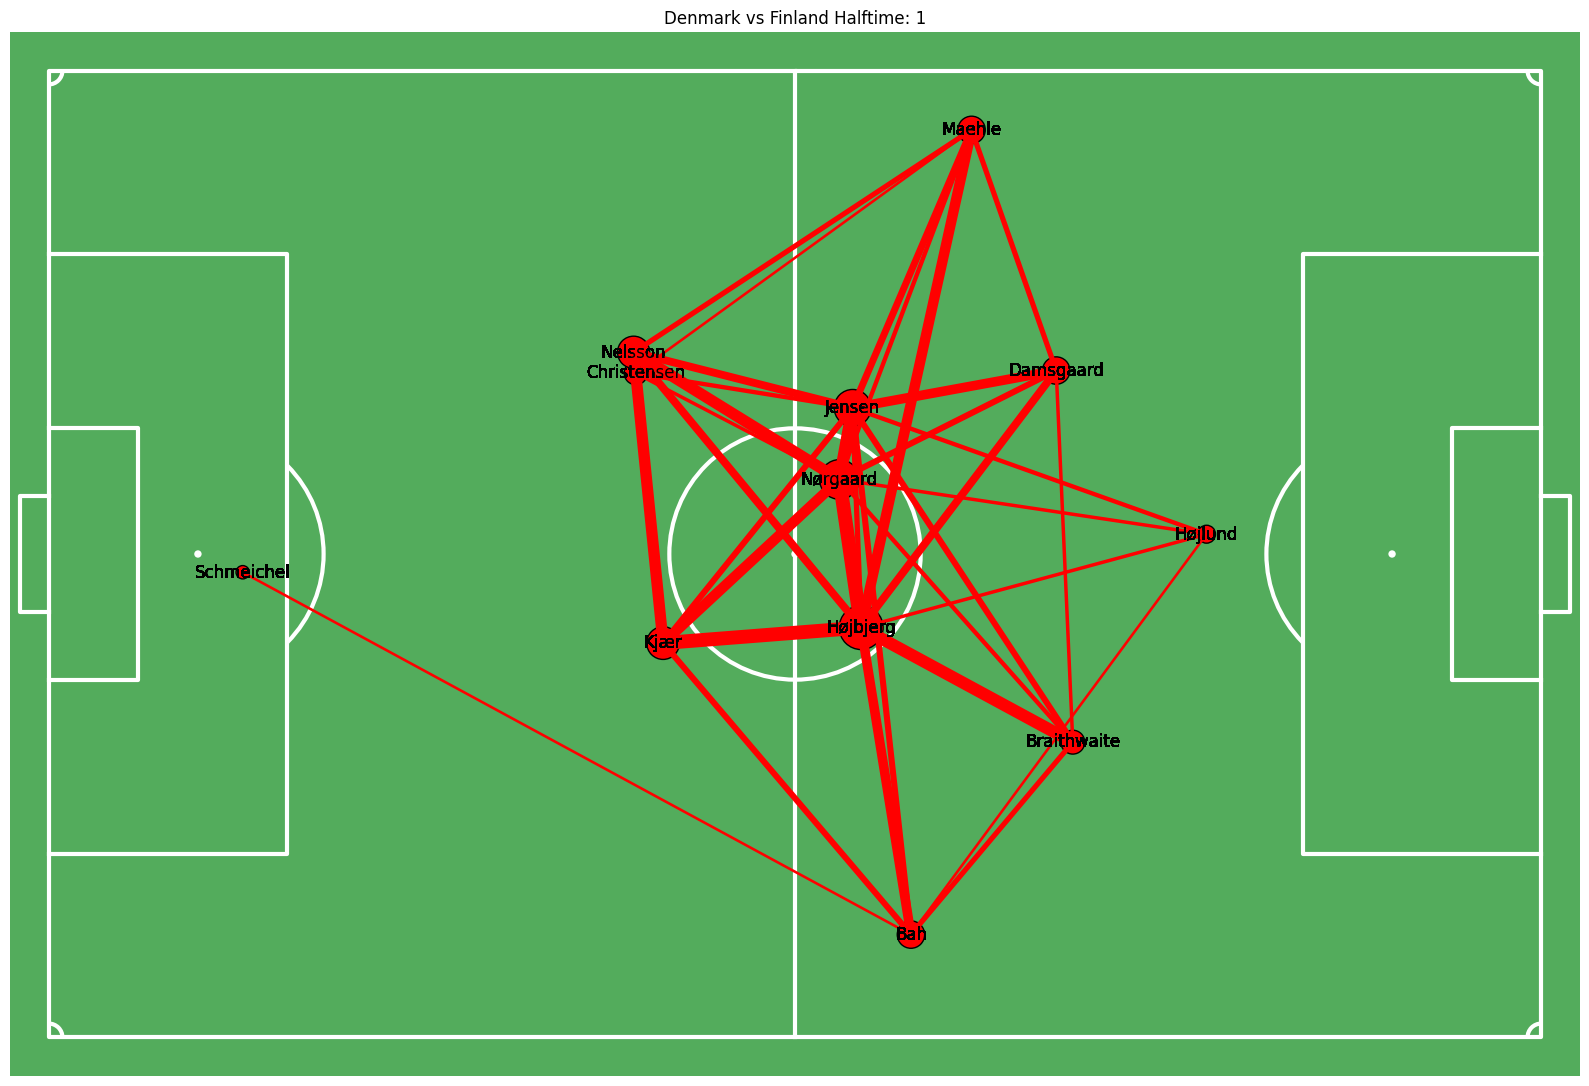

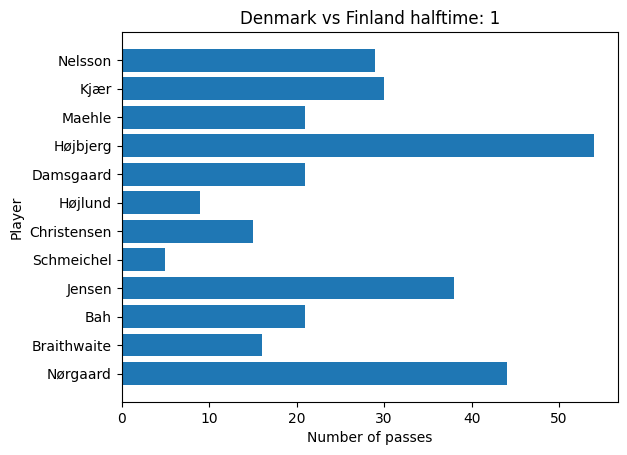

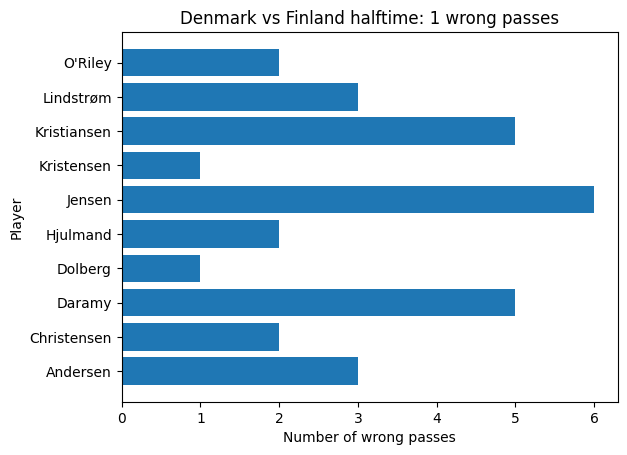

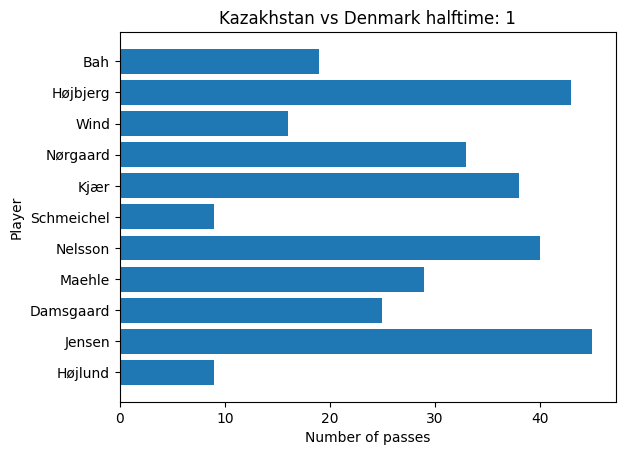

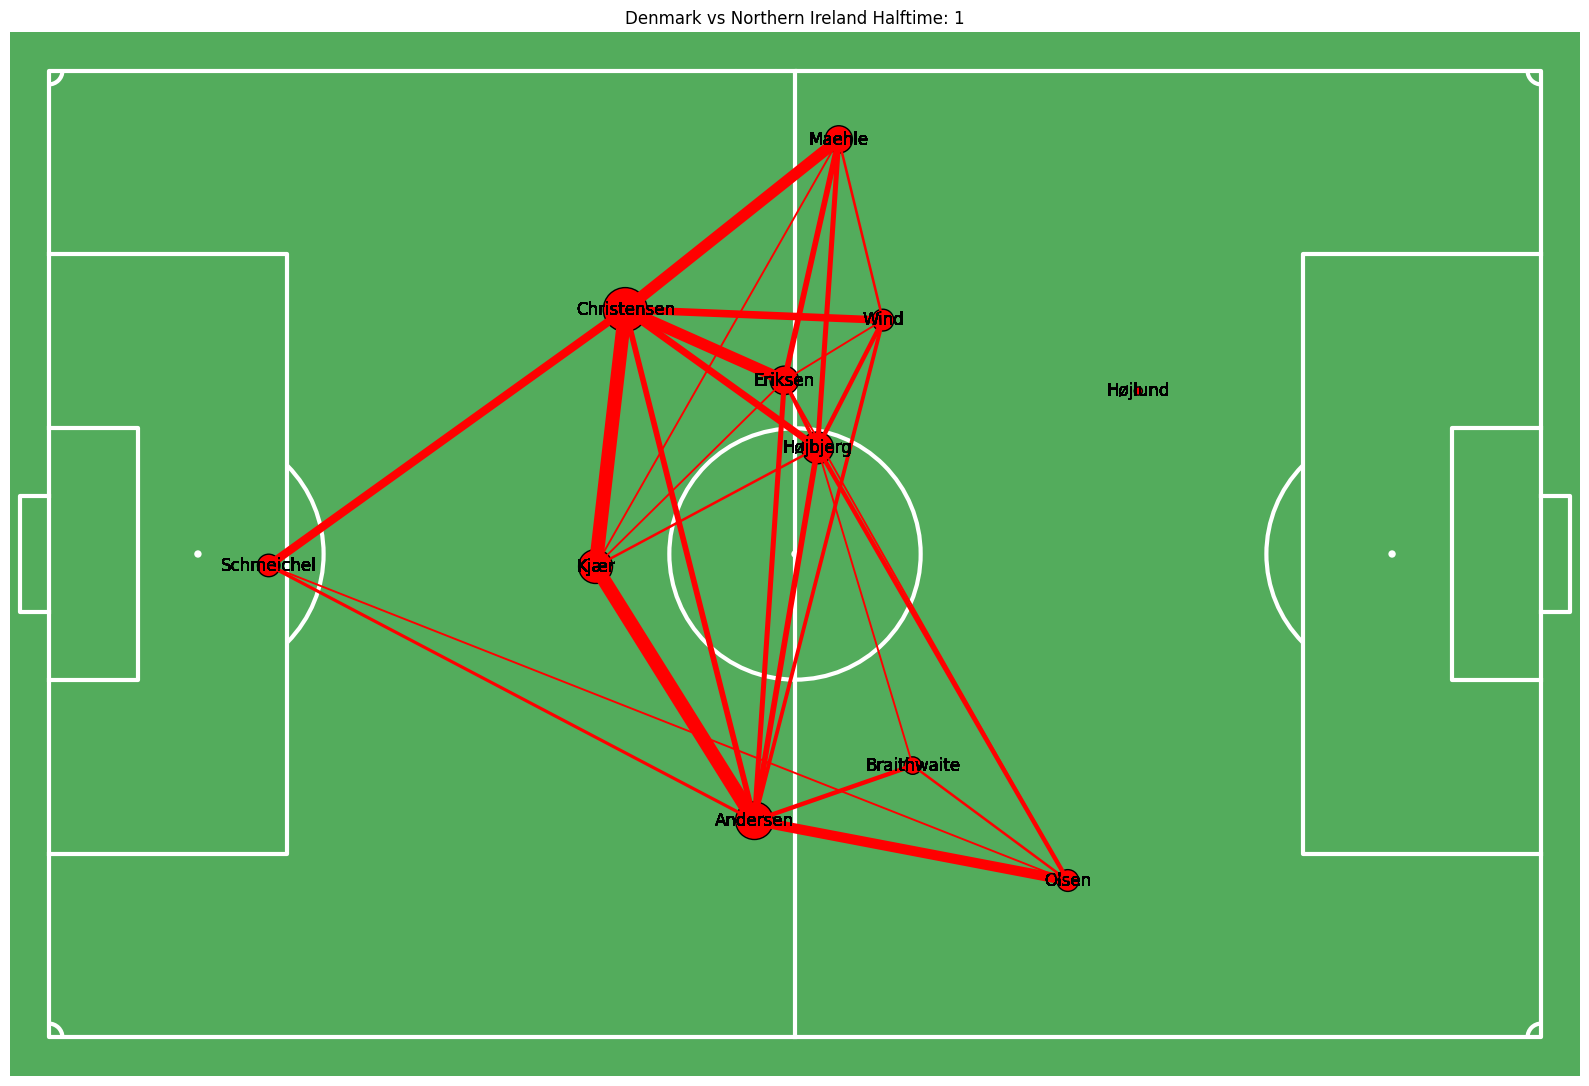

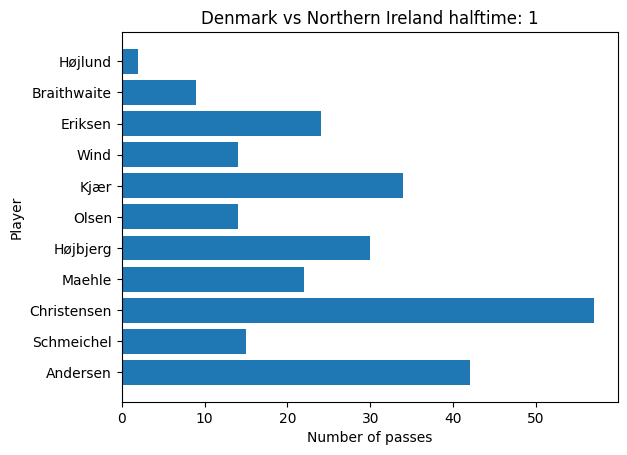

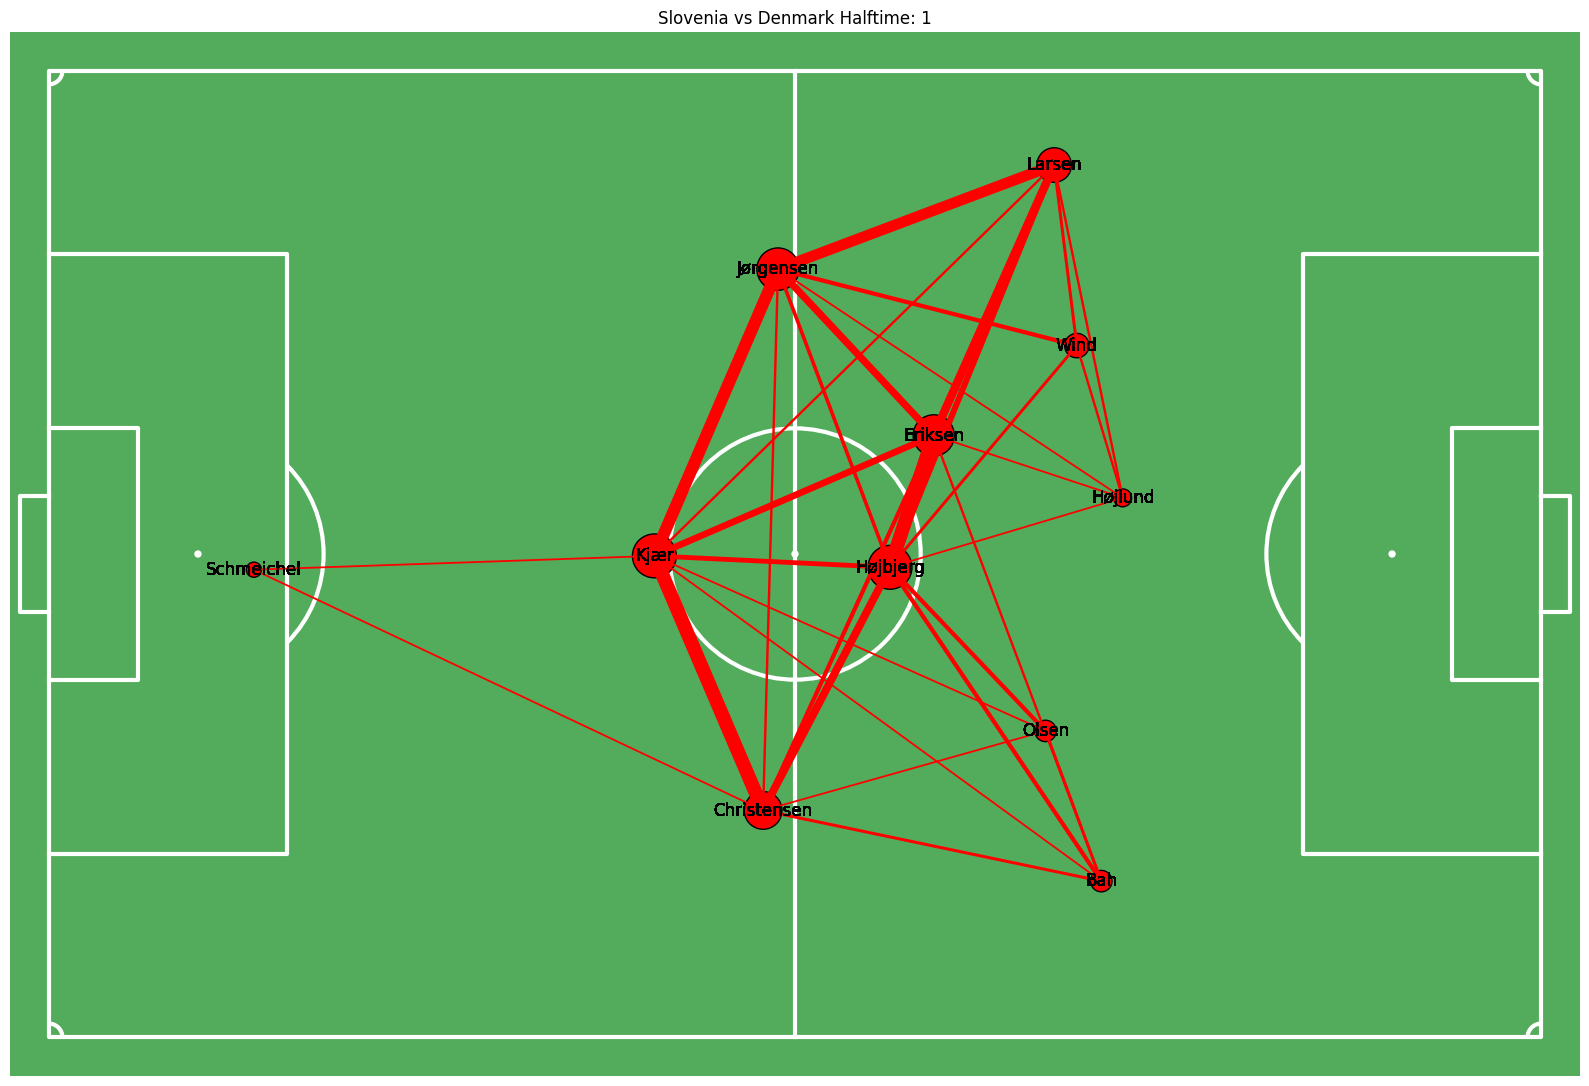

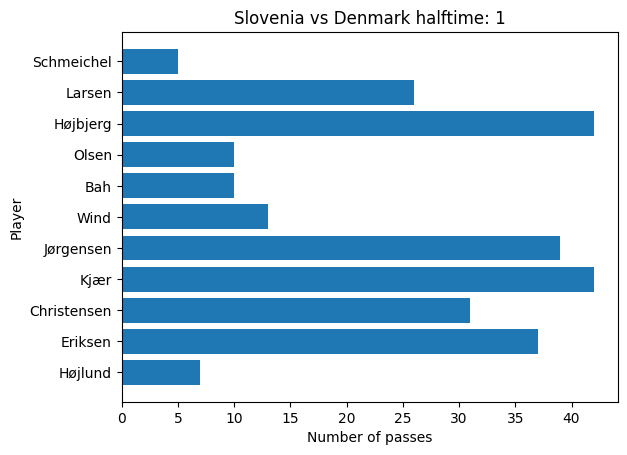

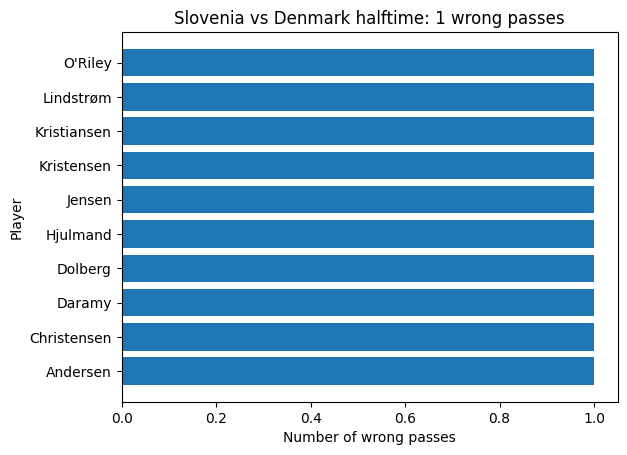

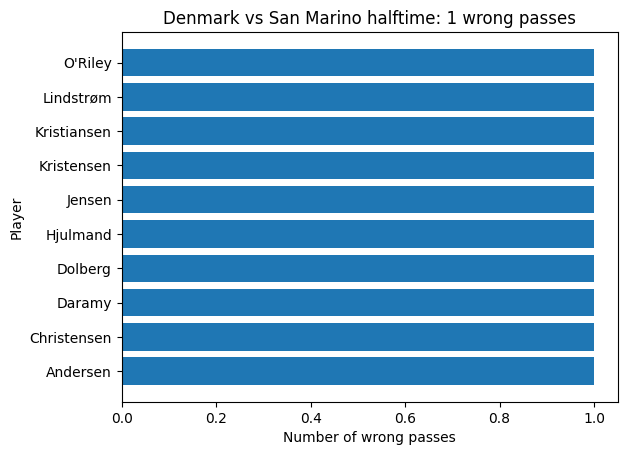

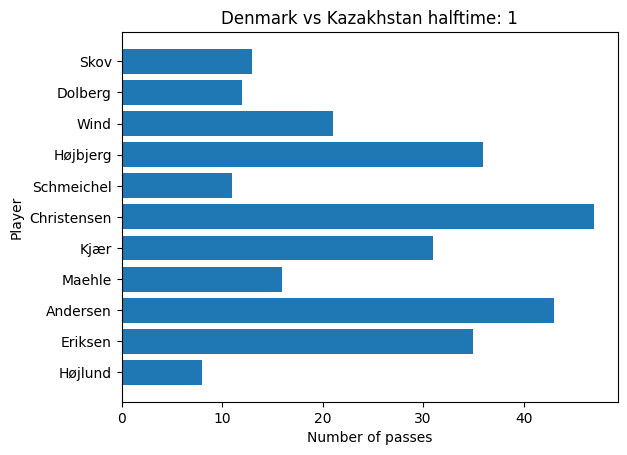

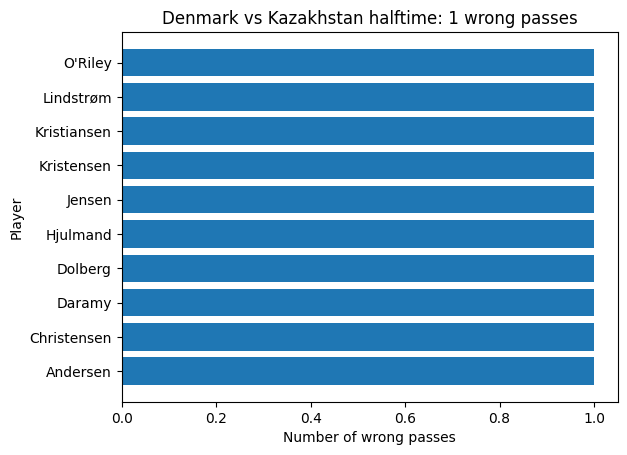

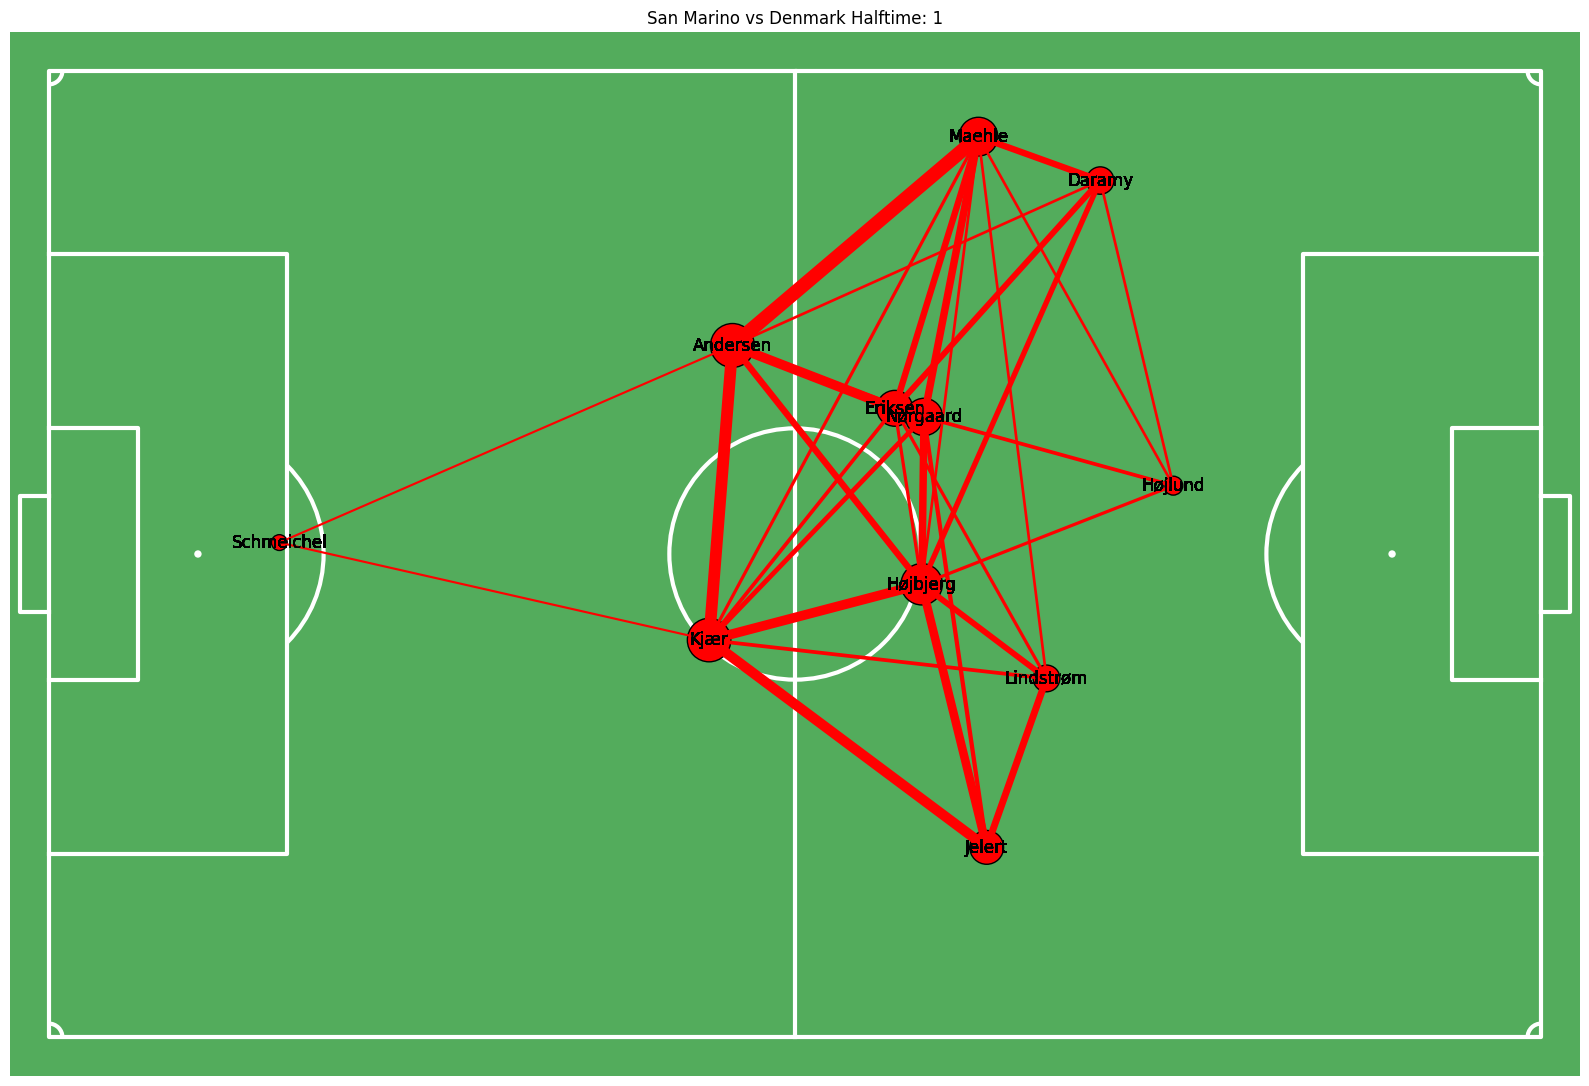

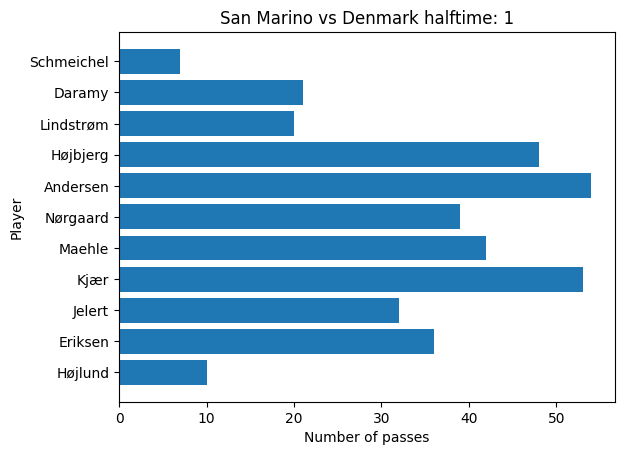

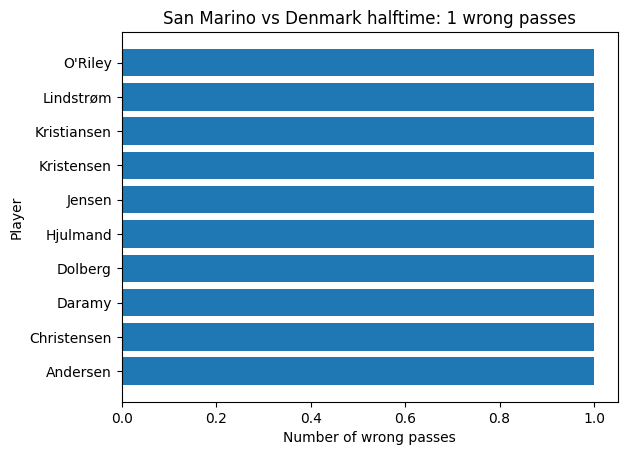

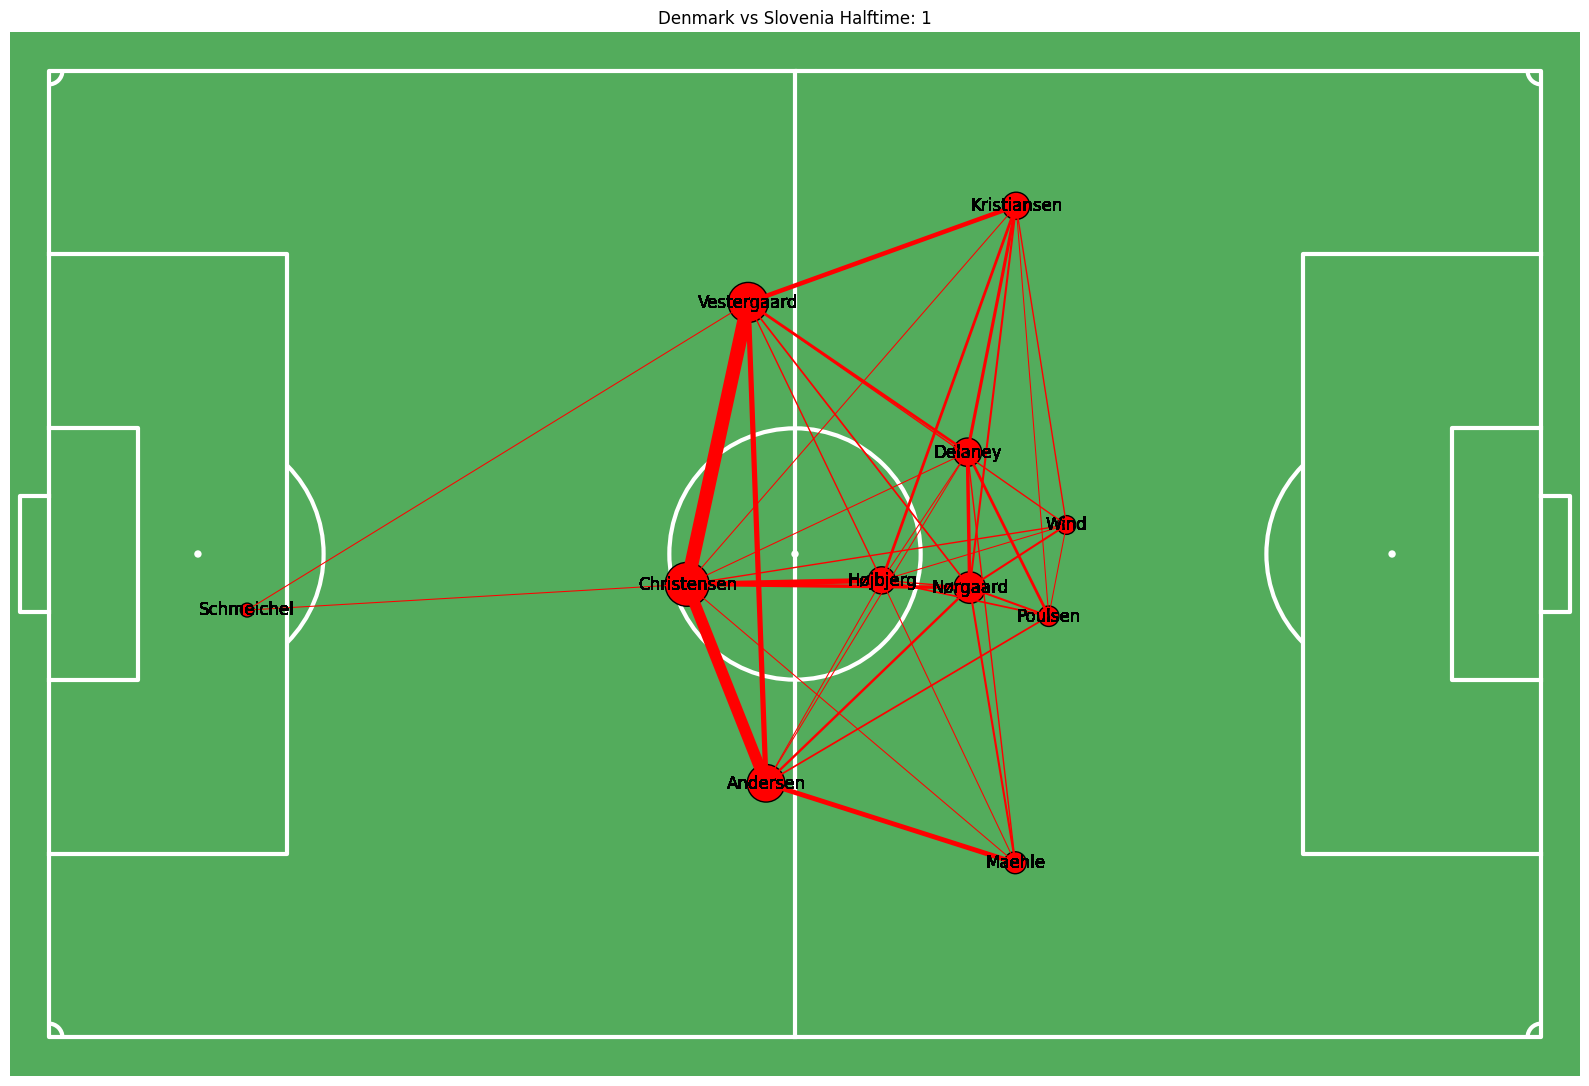

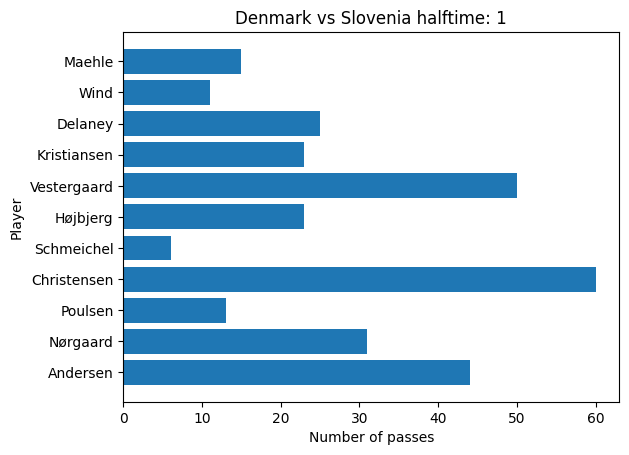

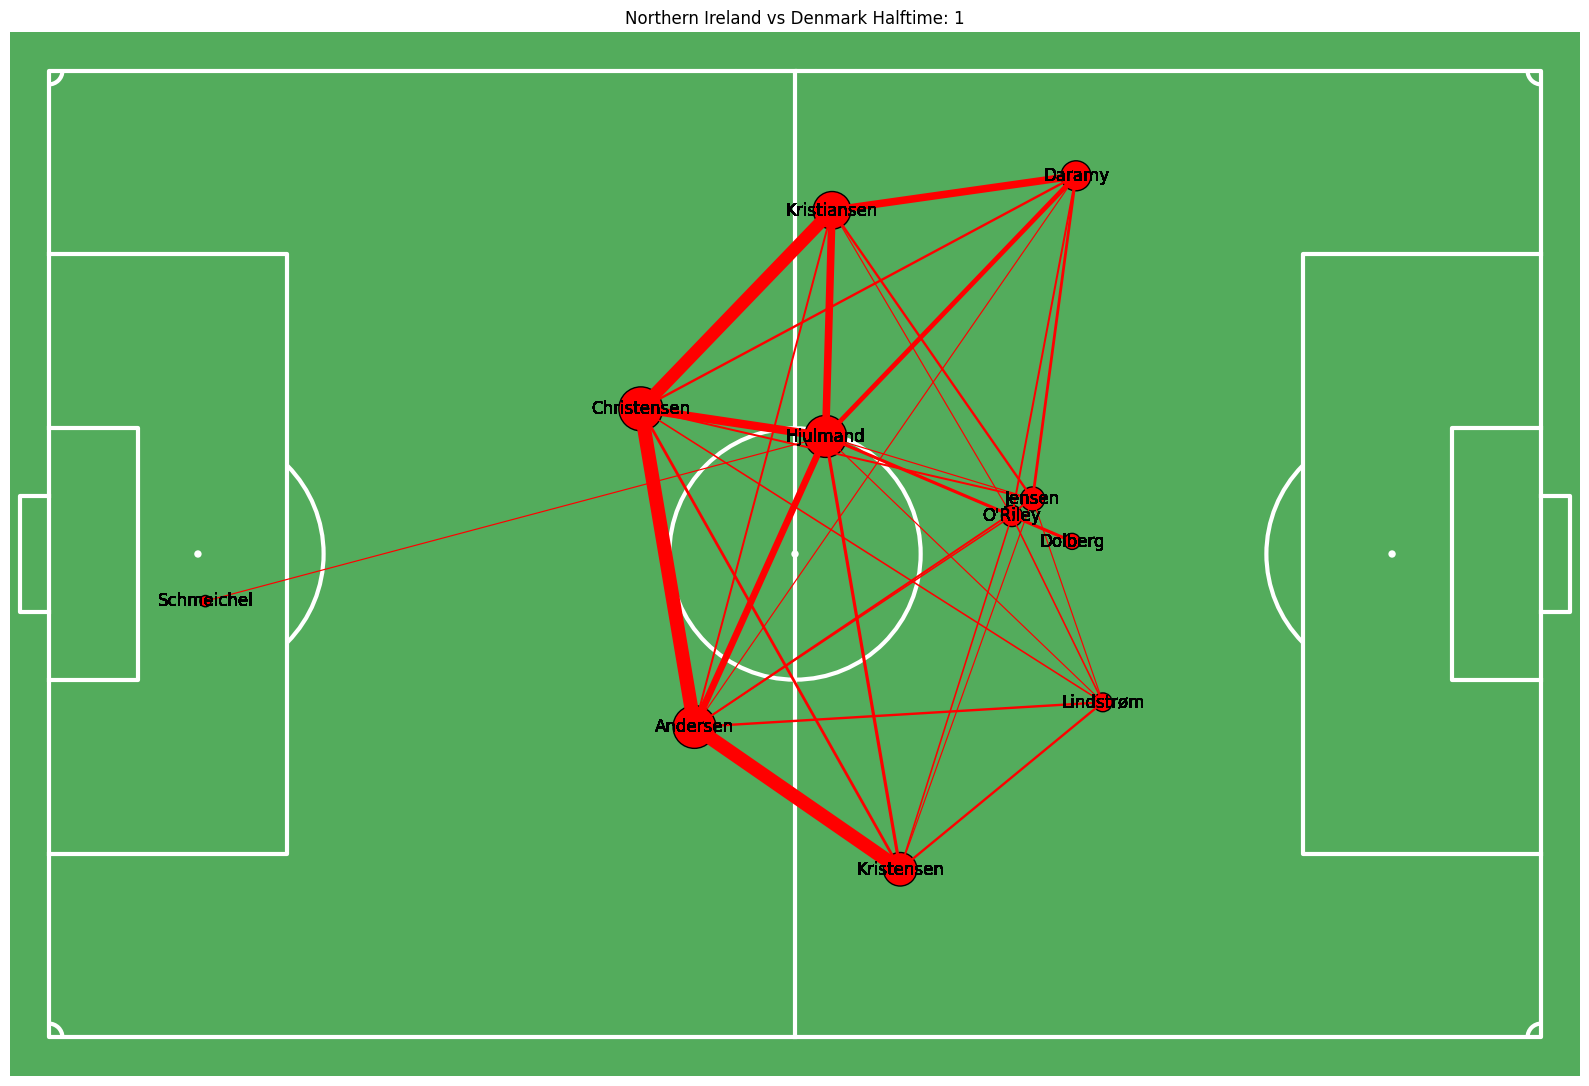

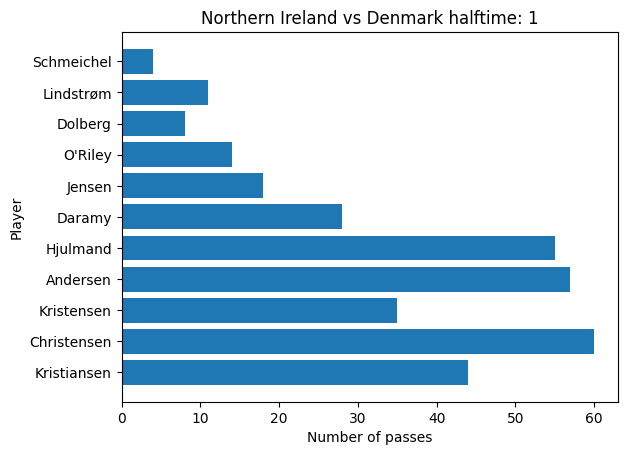

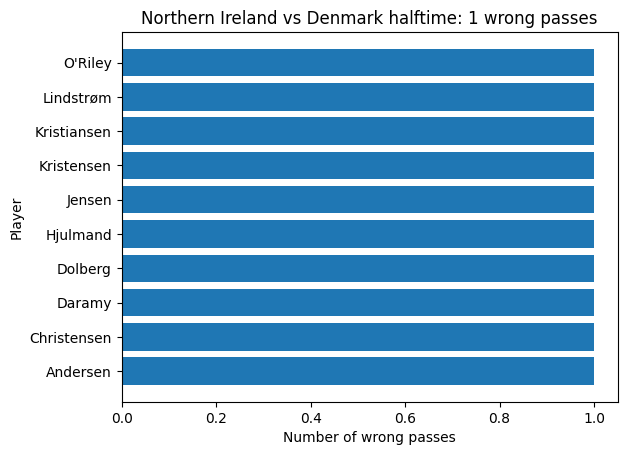

C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["matchPeriod"] = df["matchPeriod"].apply(lambda x: 1 if x == "1H" else 2)
C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\246901810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

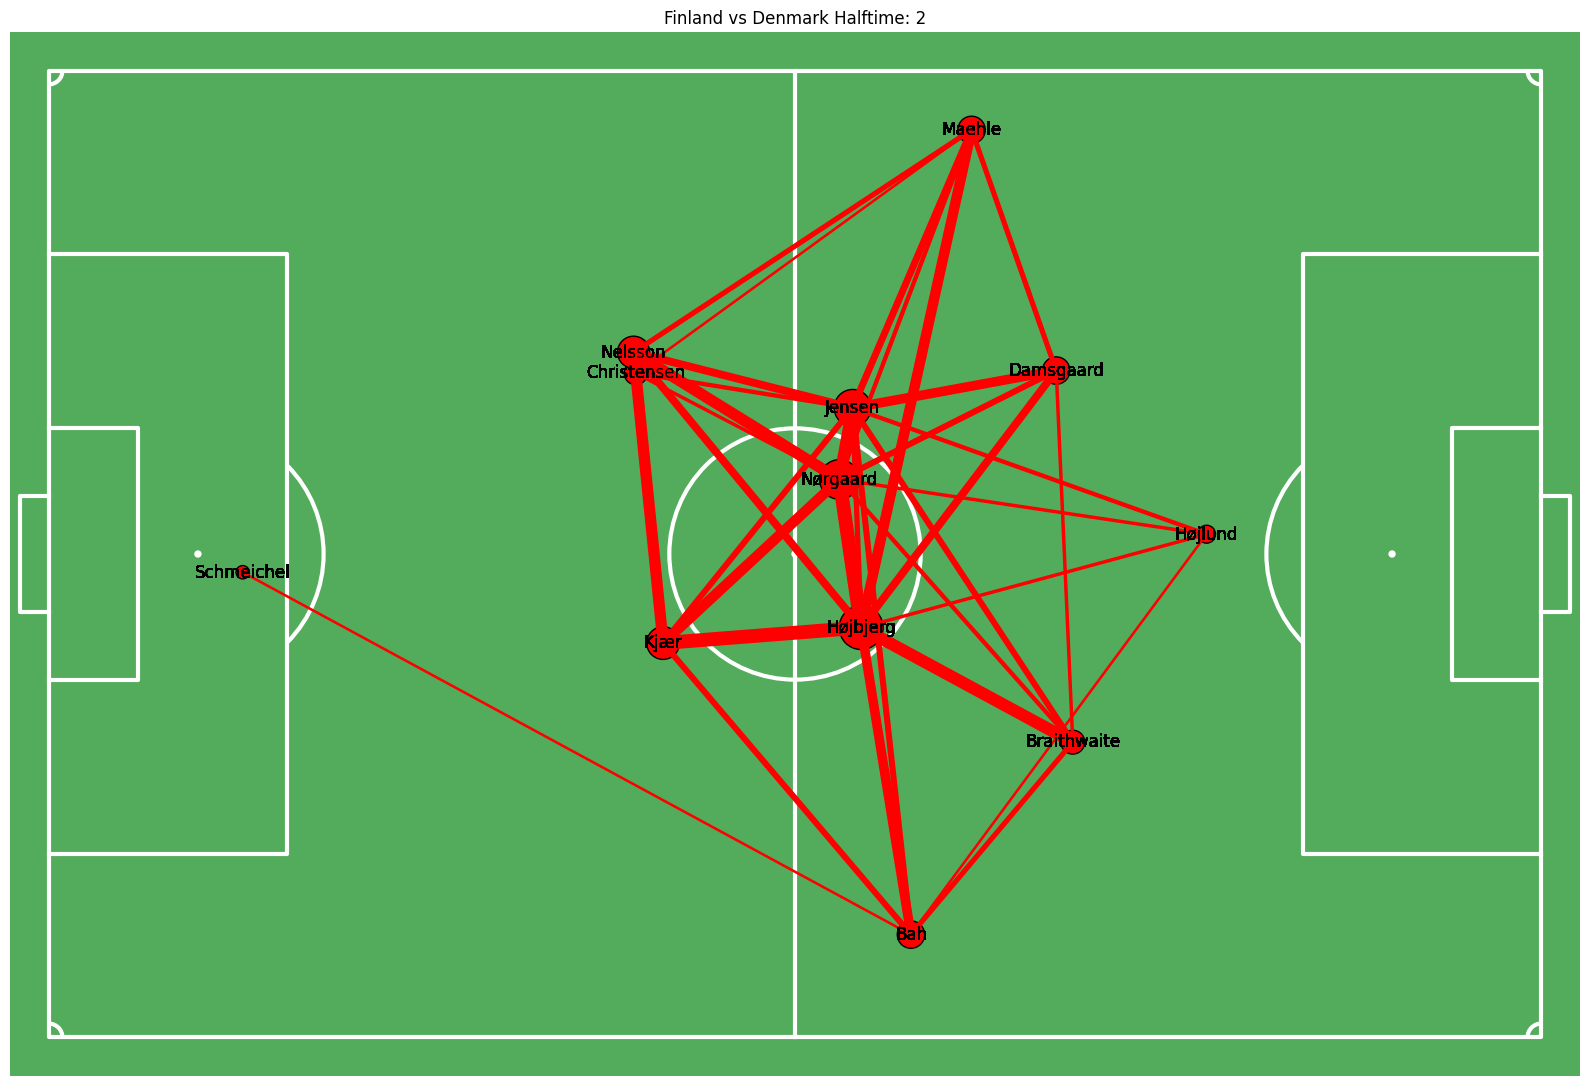

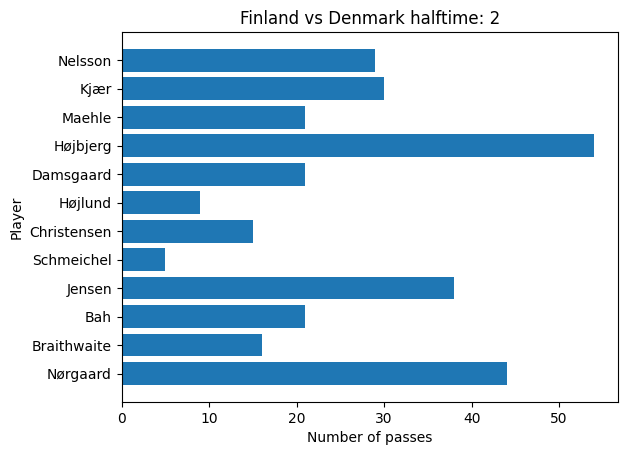

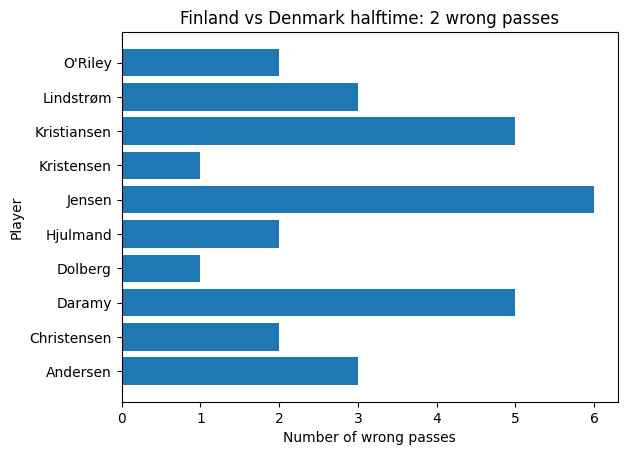

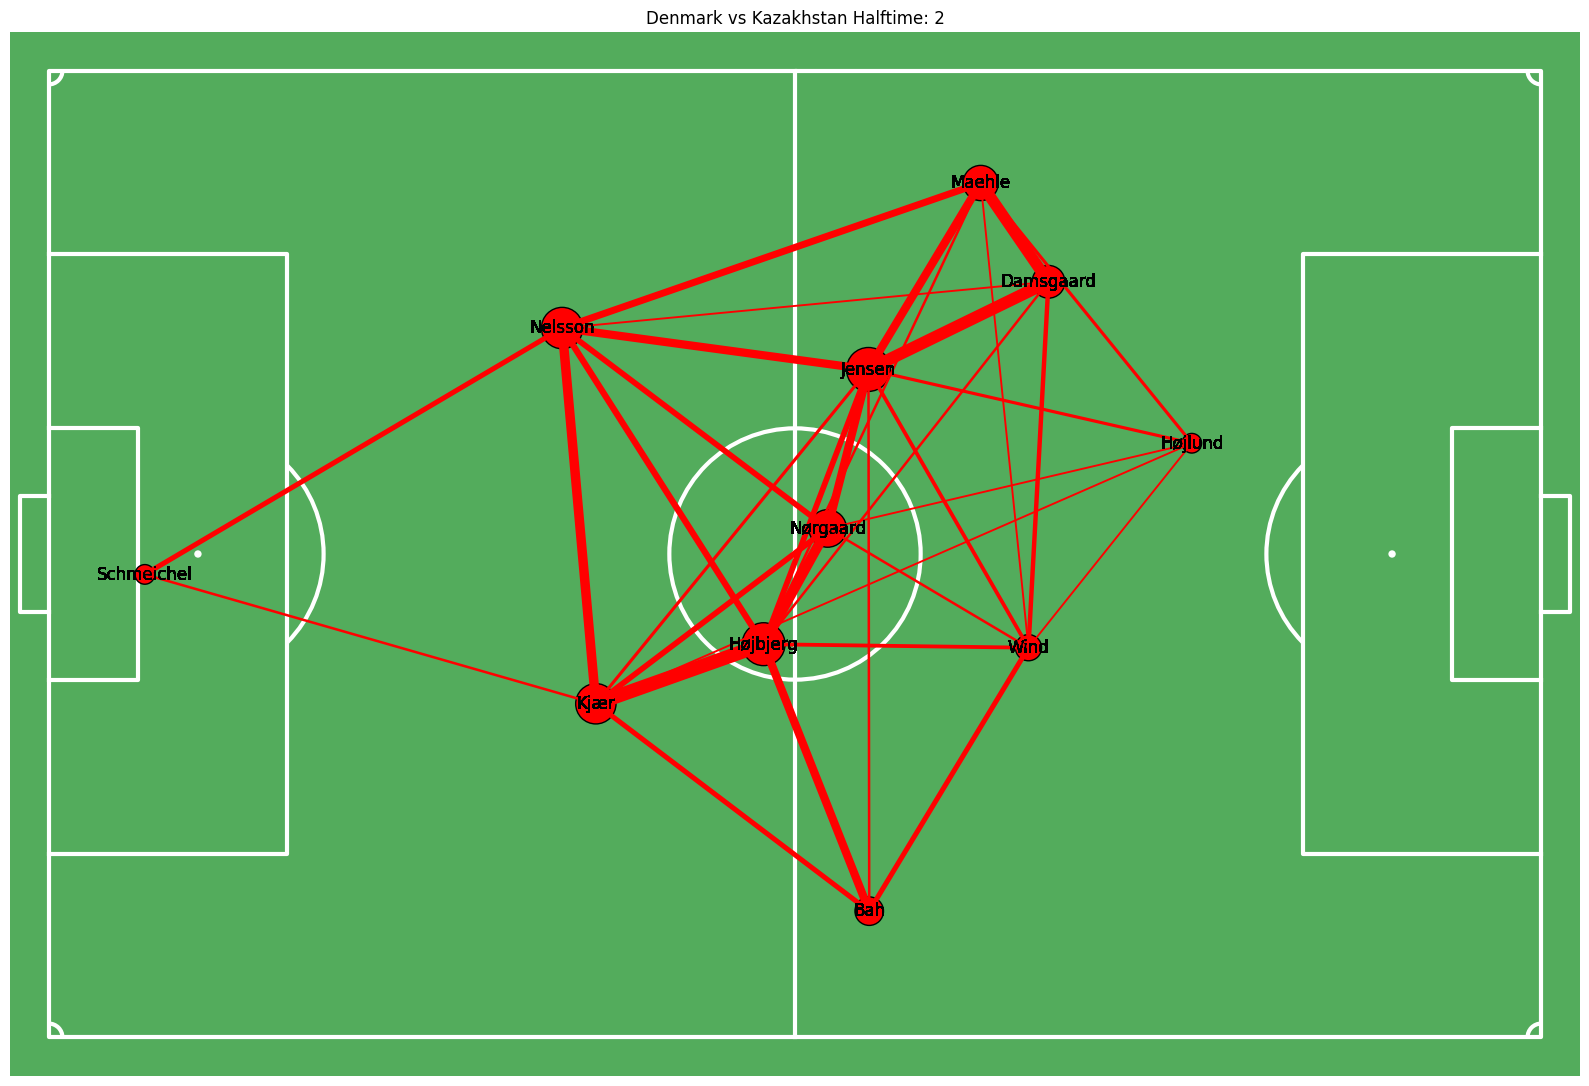

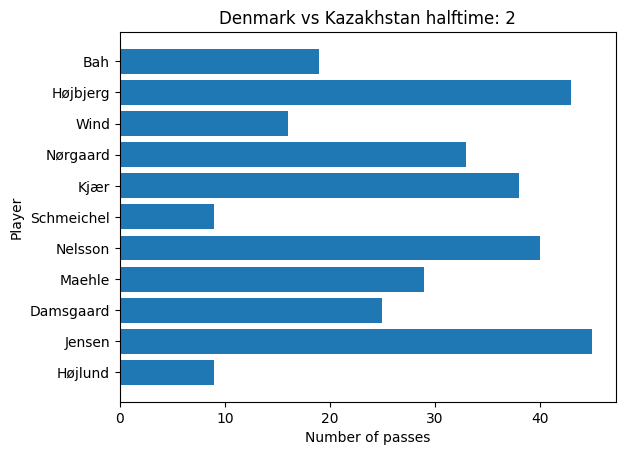

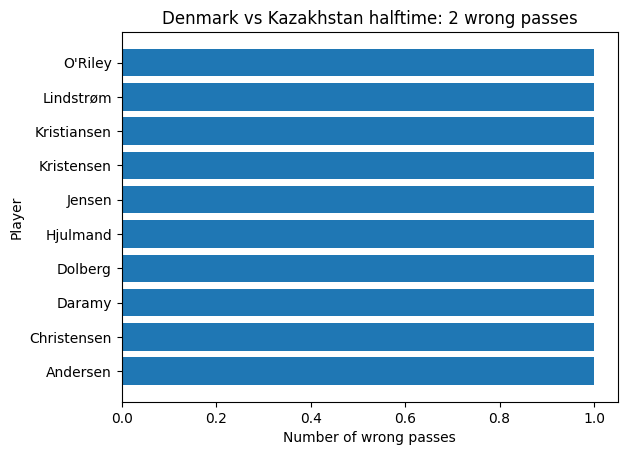

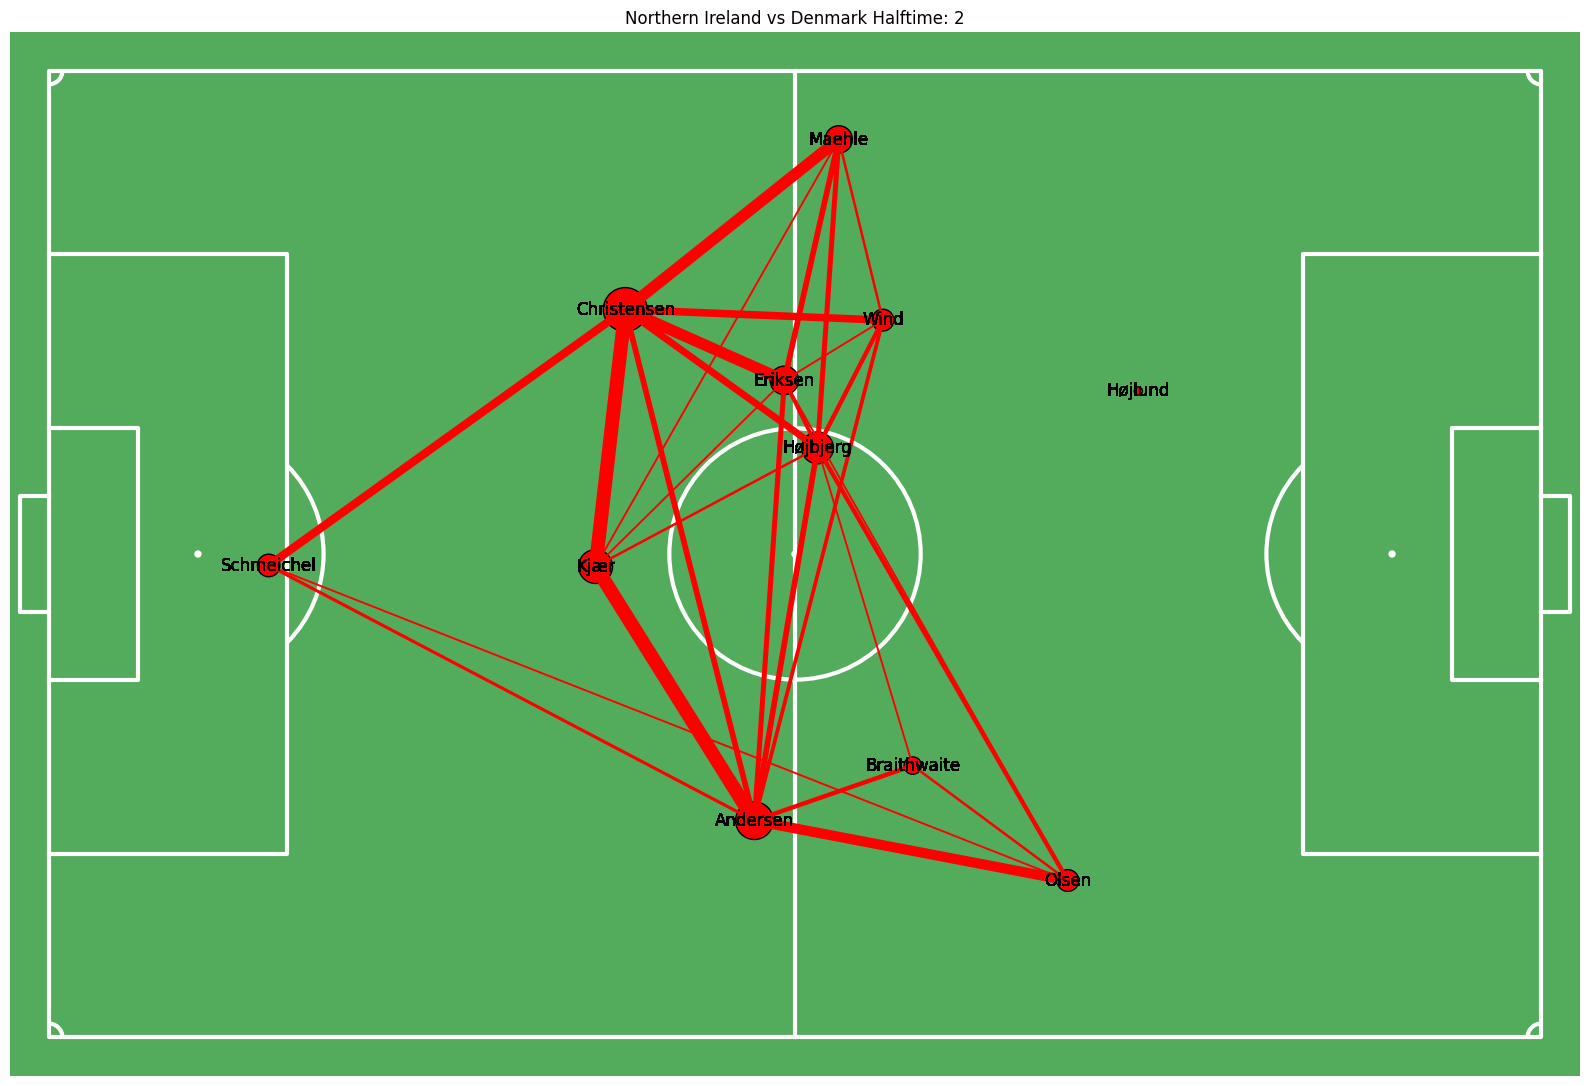

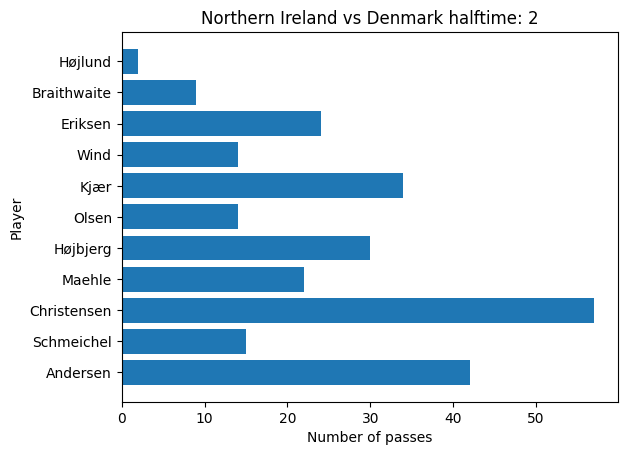

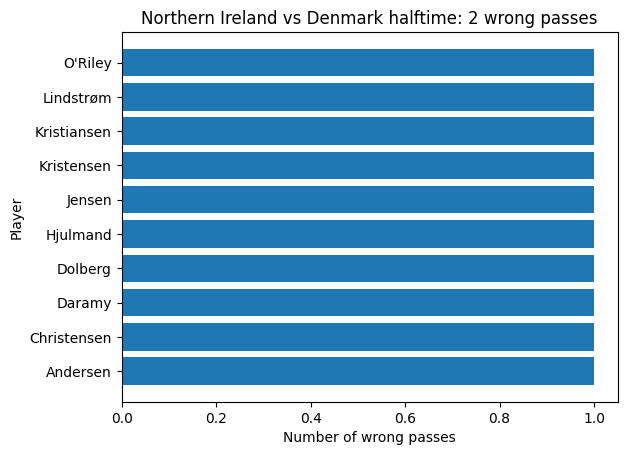

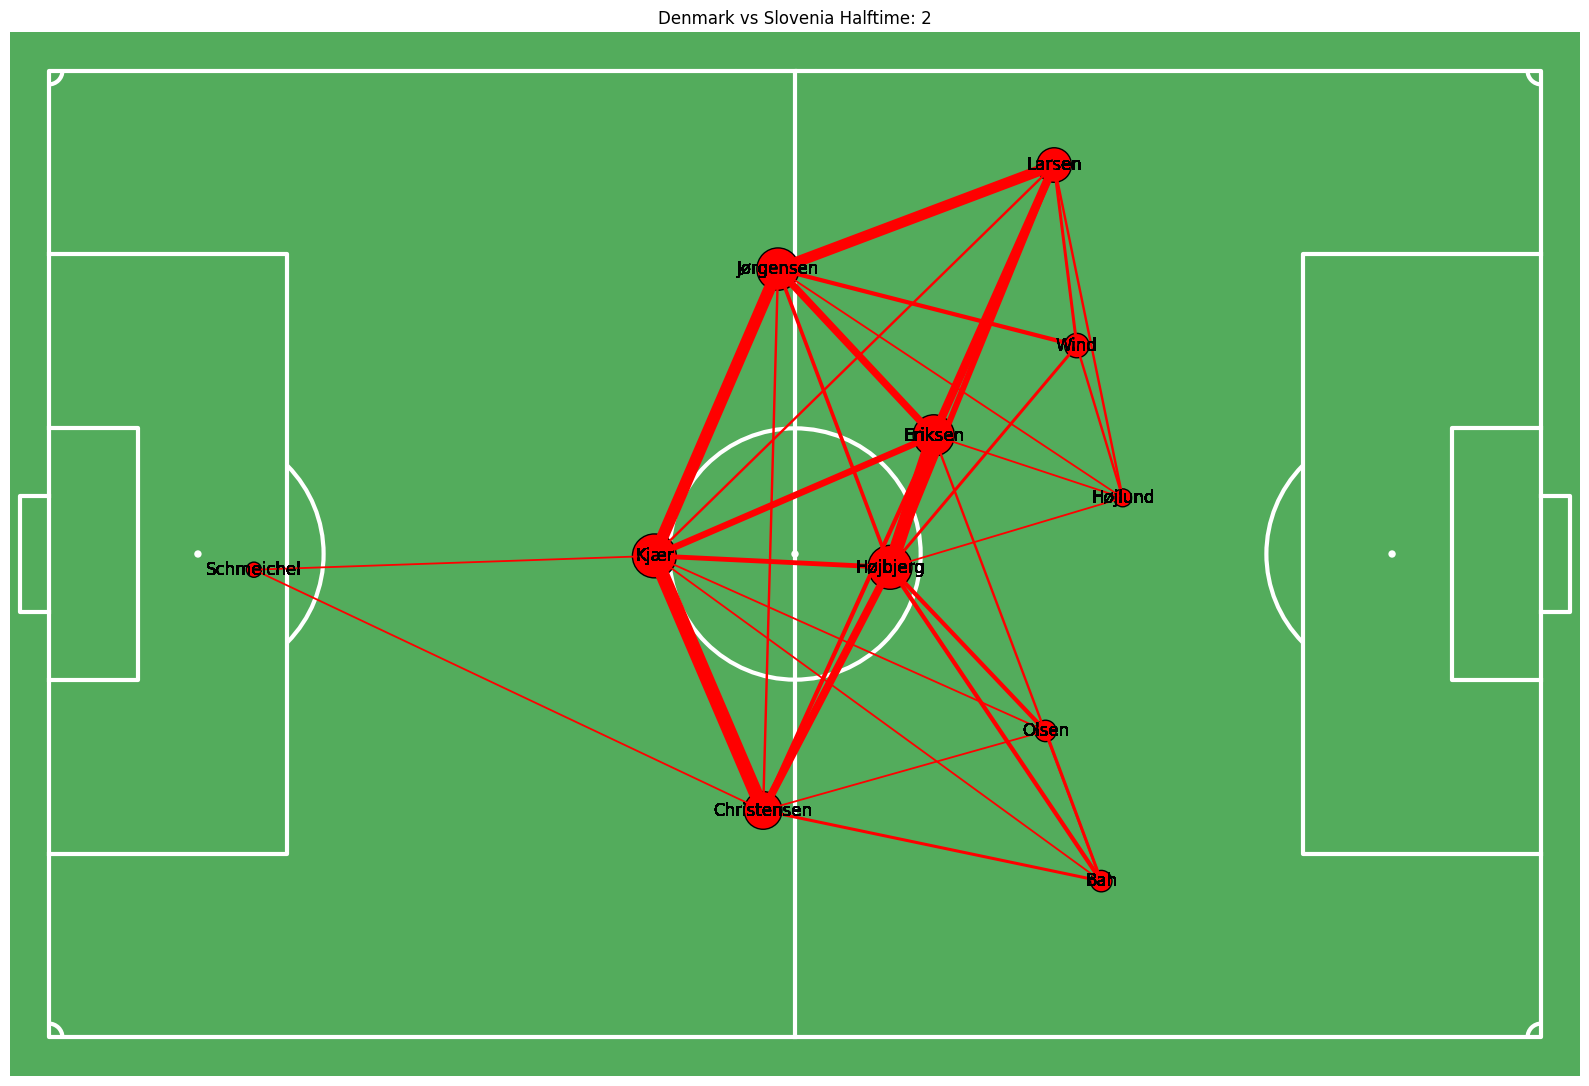

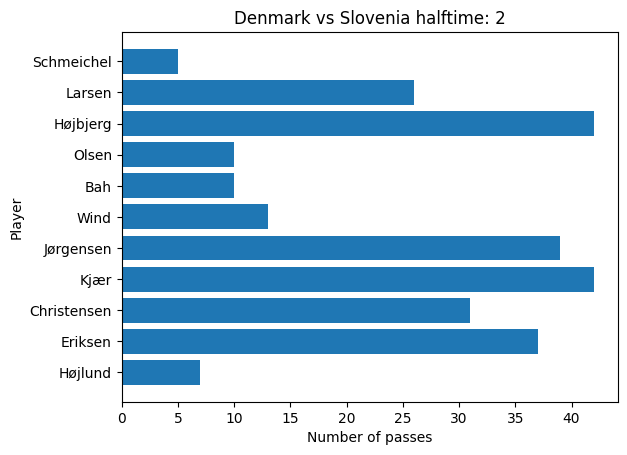

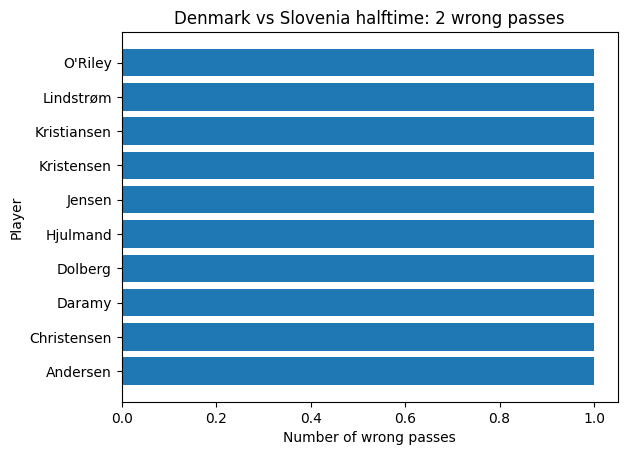

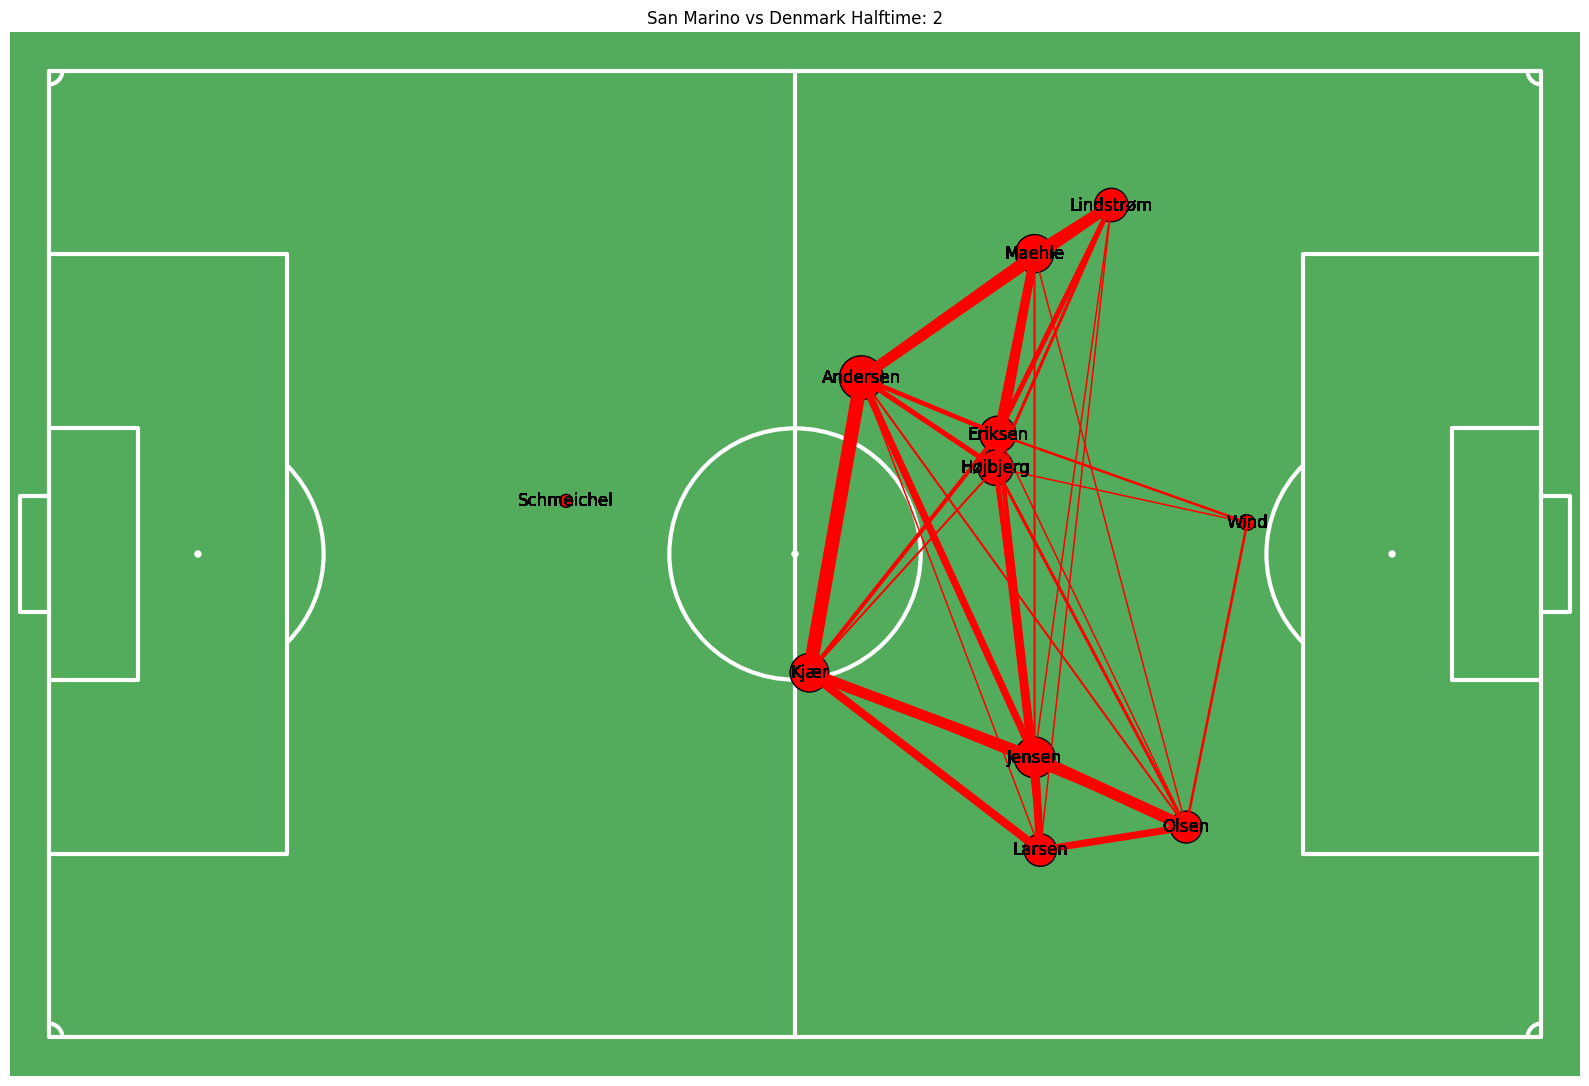

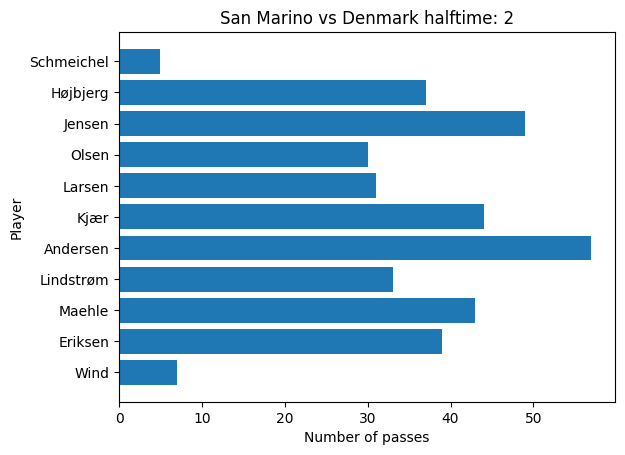

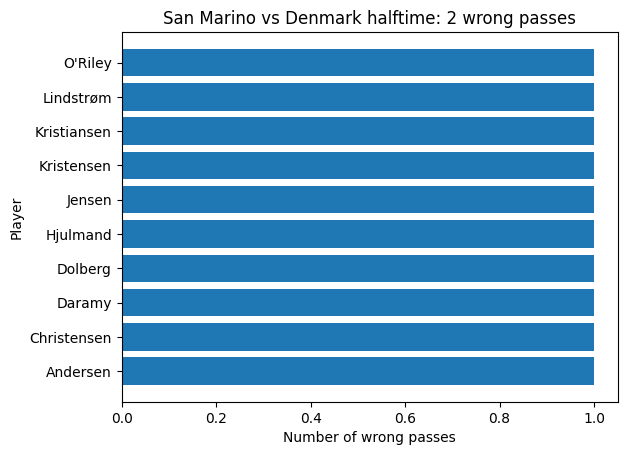

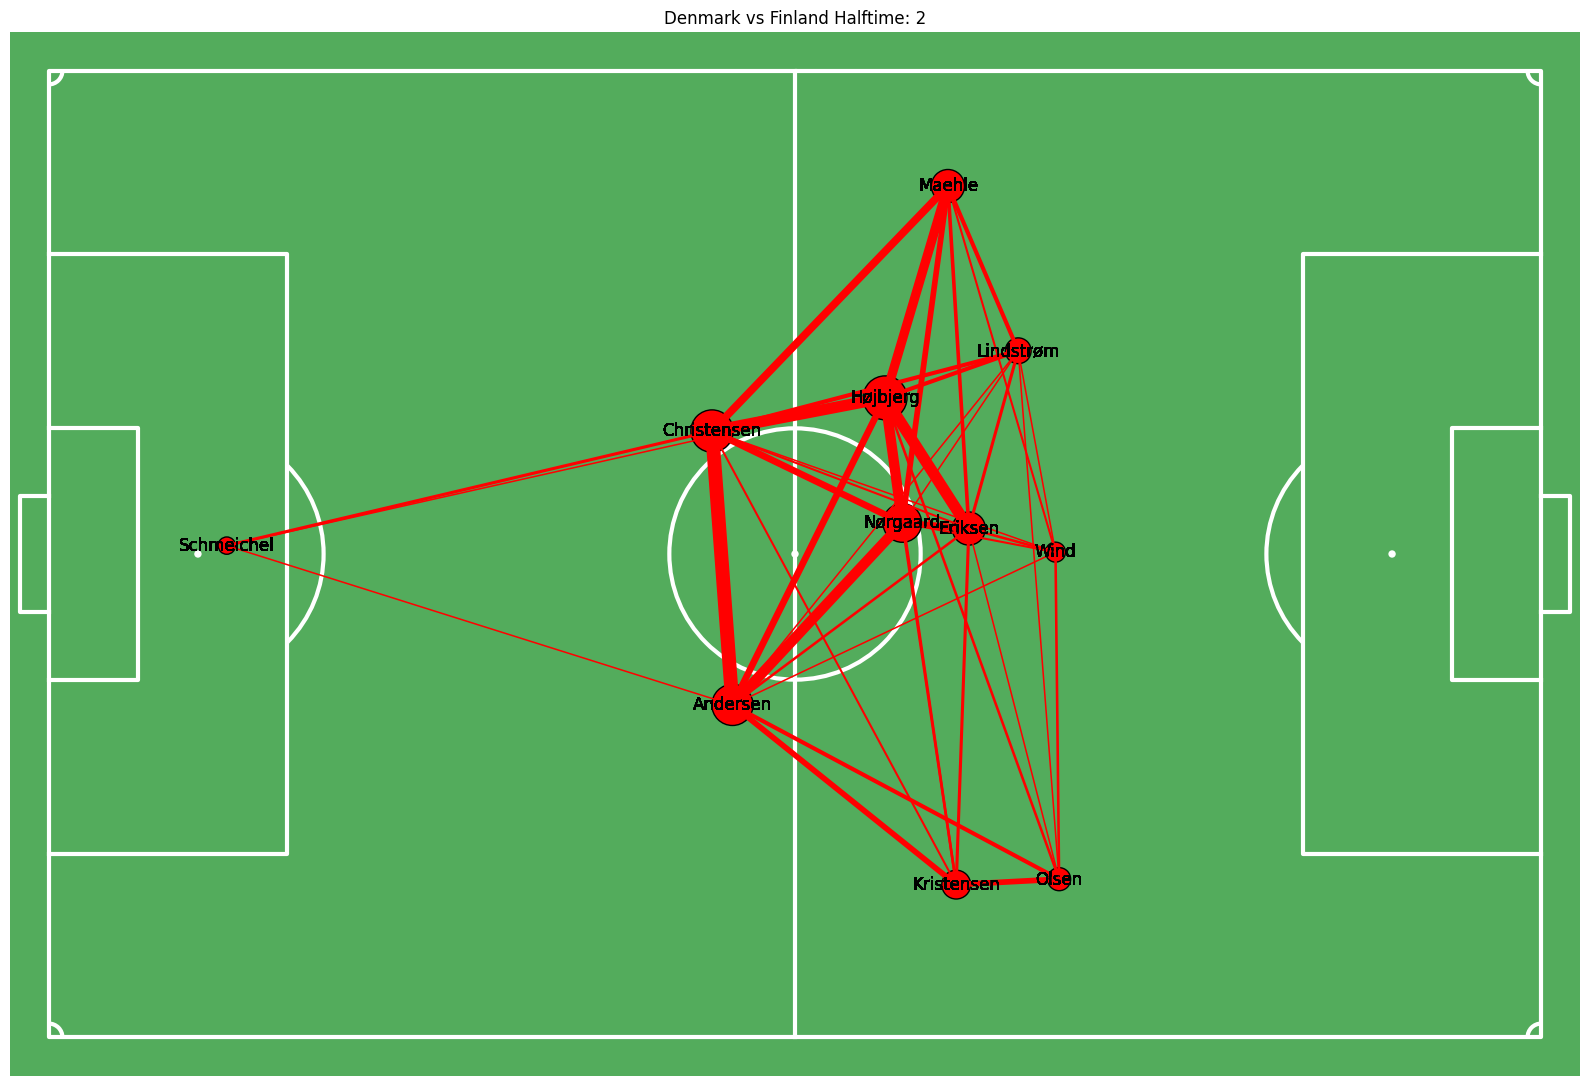

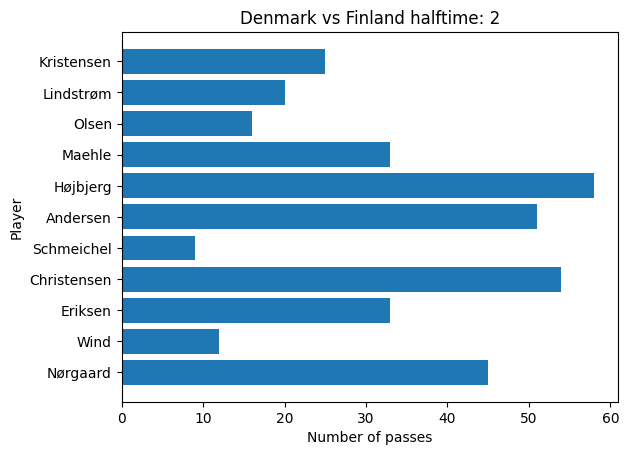

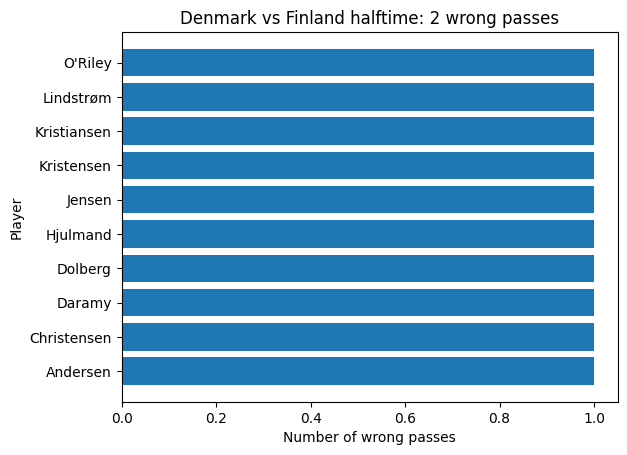

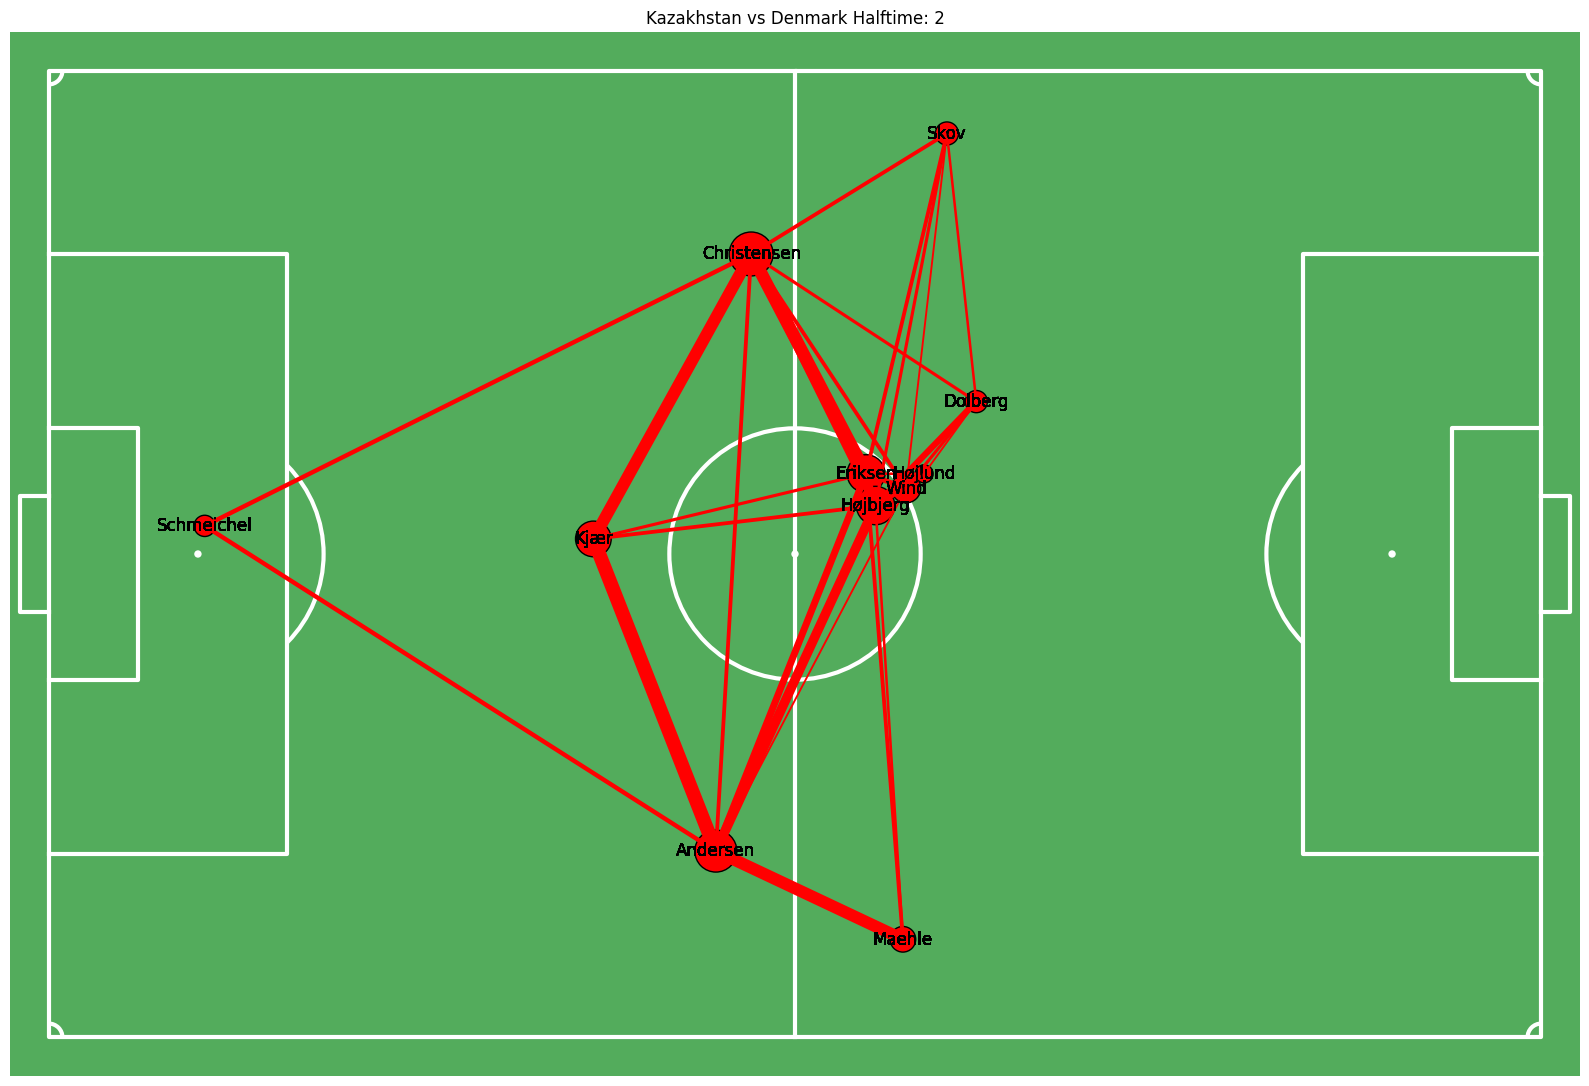

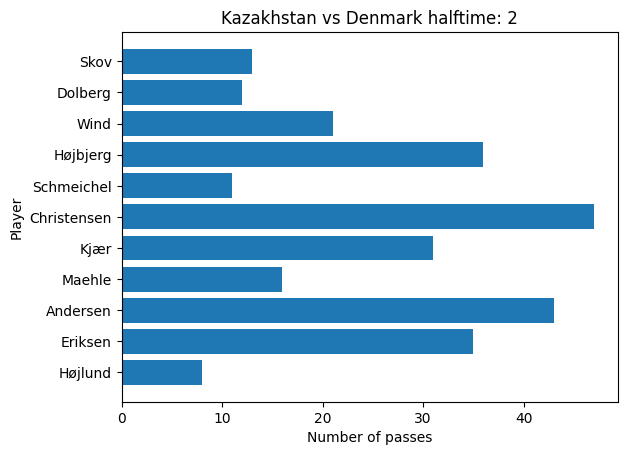

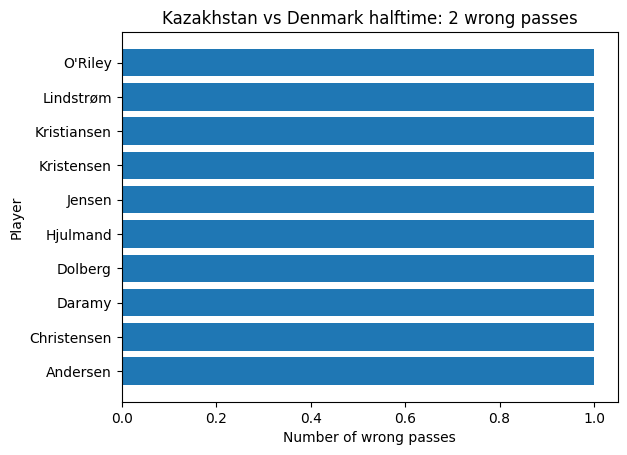

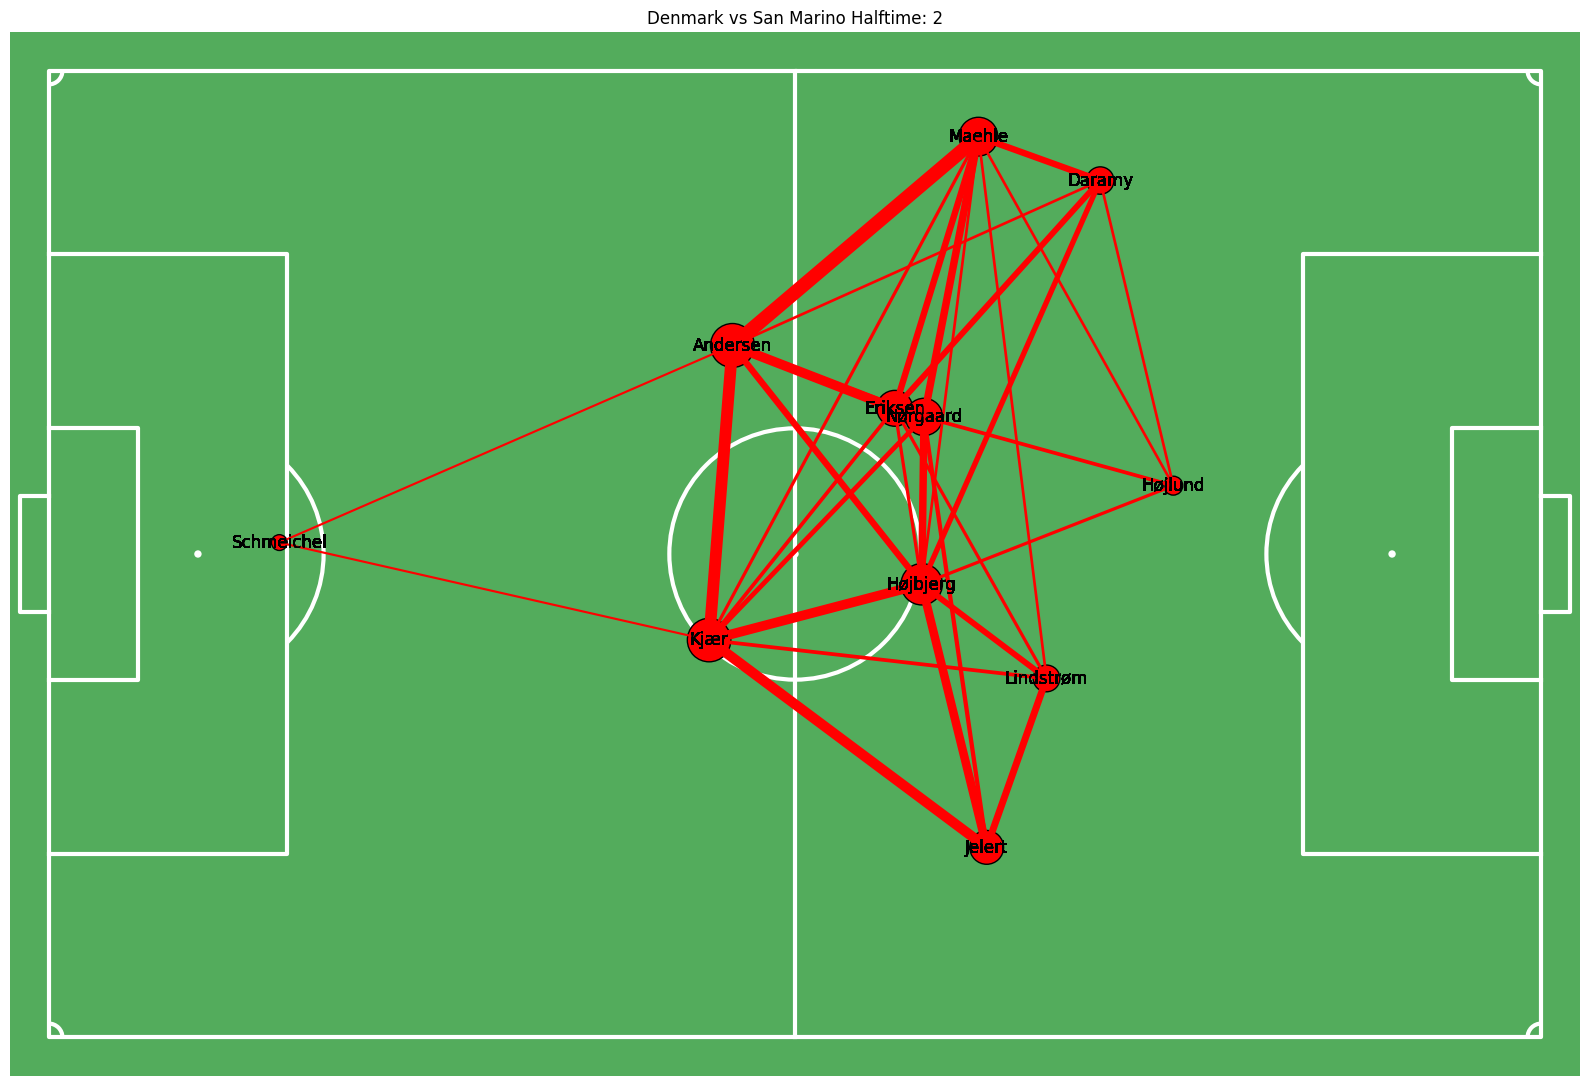

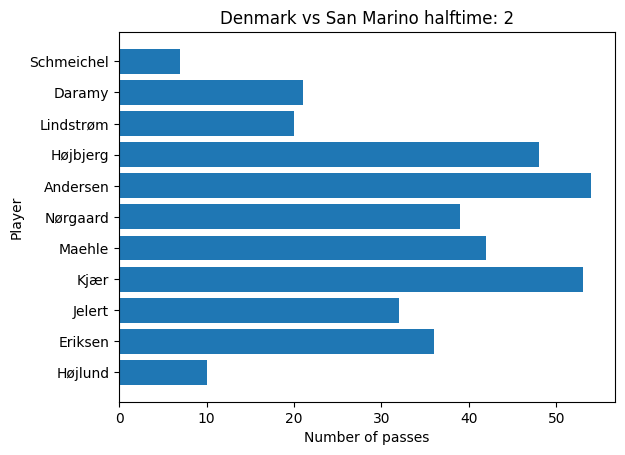

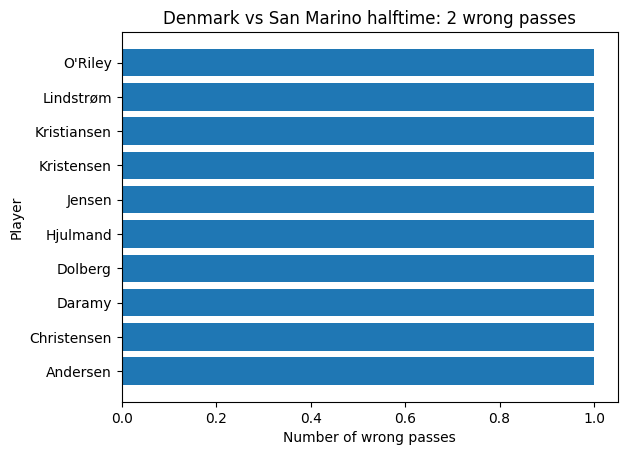

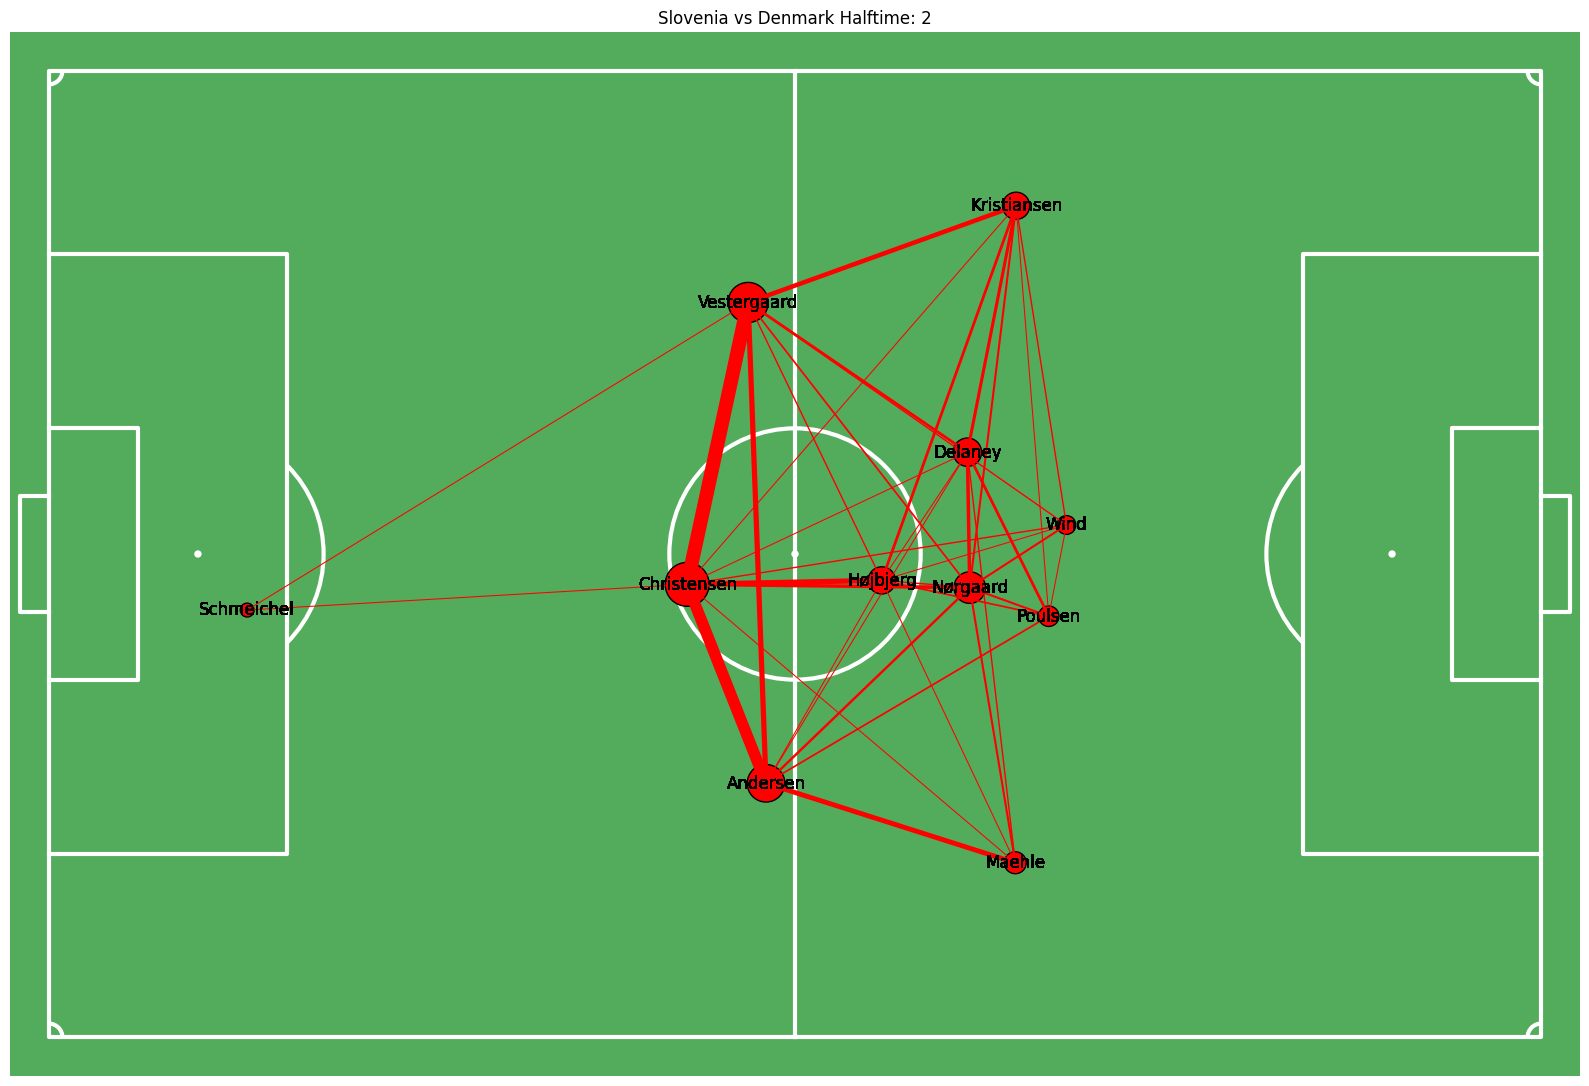

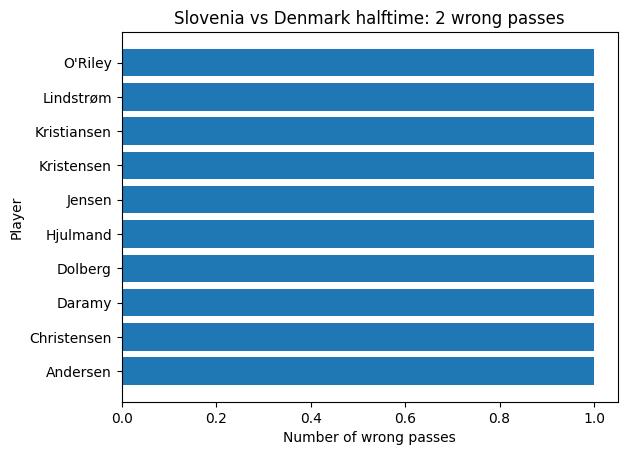

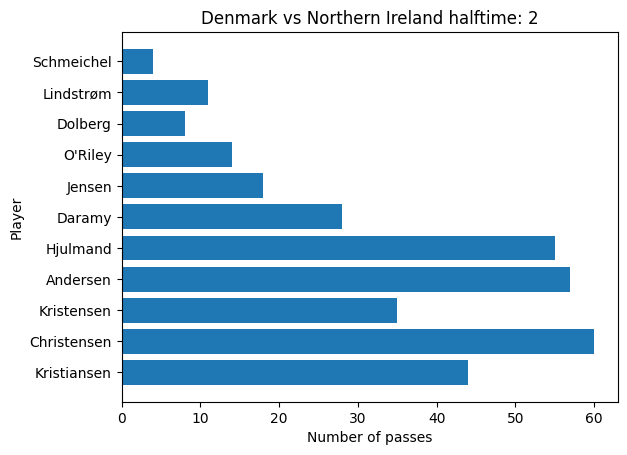

In [10]:

current_directory = Path.cwd()
current_directory = current_directory.parents[0]

teams = [ 'Denmark'] #teams to investigate

for team in teams:
    data_dir = os.path.join(current_directory,'data',f'{team}_games')
    data_dir = Path(data_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    data_dir = Path(data_dir)

    data_path= os.path.join(current_directory,'data')
    wyscout_path = os.path.join(data_path,'wyscout')
    input_dir = os.path.join(data_path,'skillcorner')
    match_id_path = os.path.join(data_path,'matchids.csv')

    match_id = pd.read_csv(match_id_path)
    team_match = match_id[(match_id['home'] == team) | (match_id['away'] == team)]
    team_match_ids_wyscout = team_match['wyscout'].values


    for halftime in range(1,3):
        succesfull_df, failed_df, org_df = passes_visualization_halftime(team_match, wyscout_path, halftime, current_directory=current_directory, team = team)









In [15]:
org_df["type.primary"].unique()

array(['pass', 'duel', 'interception', 'touch', 'game_interruption',
       'throw_in', 'infraction', 'free_kick', 'clearance', 'corner',
       'acceleration', 'shot', 'goal_kick', 'offside', 'shot_against',
       'fairplay', 'goalkeeper_exit'], dtype=object)

In [130]:
#find the goal:
mask = org_df["shot.isGoal"] == True
#recursively find the last passes that lead to the goal
end_point_goals = org_df[mask].index
end_point = end_point_goals[0]
goal_df = org_df.iloc[:end_point+1]
#team that scored the goal
team_scored = goal_df["possession.team.name"].unique()[0]

#select from the end where the goal_df["possession.team.name"] is not anymore  team_scored
start_point_mask = goal_df["possession.team.name"] != team_scored
start_point = goal_df[start_point_mask].index[-1]

                      

In [131]:
goal_df = org_df.iloc[start_point+1:end_point+1]
#TODO: Needs better start point as there is a normalizing error present see: the columns possesion.endlocation etc. shift if i dont use +1


In [143]:
#visualize the passing network that lead to the goal from the wyscout data
pitch = Pitch(pitch_type='wyscout', goal_type='box', pitch_color='#53ac5c',
                            line_color='white', linewidth=3, corner_arcs=True)
fig, ax = pitch.draw(figsize=(10, 11))

index_naive = 0
#filter either shot or passes
for row in goal_df.iterrows():
    row = row[1]
    index = row[0]
    if (row["type.primary"] == "pass") | (row["type.primary"] == "shot"):
        player_name = row["player.name"]
        rec_name = row["pass.recipient.name"]
        x_loc = row["location.x"]
        y_loc = row["location.y"]
        x_end_loc = row["pass.endLocation.x"]
        y_end_loc = row["pass.endLocation.y"]
        pitch.annotate("", xy=(x_end_loc, y_end_loc), xytext=(x_loc, y_loc), arrowprops=dict(arrowstyle="->", color='red', lw=2), ax=ax, zorder=2)
        pitch.annotate(player_name , xy=(x_loc, y_loc), ax=ax, fontsize=12, ha='center', va='center', zorder=2)
        pitch.annotate(rec_name, xy=(x_end_loc, y_end_loc), ax=ax, fontsize=12, ha='center', va='center', zorder=2)
    
    elif (row["type.primary"]== "touch") :
        x_loc = x_end_loc
        y_loc = y_end_loc
        next_row = goal_df.iloc[index_naive+1]
        x_end_loc = next_row["location.x"]
        y_end_loc = next_row["location.y"]
        pitch.annotate("", xy=(x_end_loc, y_end_loc), xytext=(x_loc, y_loc), arrowprops=dict(arrowstyle="->", color='blue', lw=2), ax=ax, zorder=2)
        pitch.annotate(rec_name , xy=(x_loc, y_loc), ax=ax, fontsize=12, ha='center', va='center', zorder=2)
    
    elif row["type.primary"]== "duel":
        next_row = goal_df.iloc[index_naive+2] #skip two rows as he has to win the ball
        x_loc = x_end_loc
        y_loc = y_end_loc
        x_end_loc = next_row["location.x"]
        y_end_loc = next_row["location.y"]
        pitch.annotate("", xy=(x_end_loc, y_end_loc), xytext=(x_loc, y_loc), arrowprops=dict(arrowstyle="->", color='yellow', lw=2), ax=ax, zorder=2)
        #pitch.annotate(rec_name , xy=(x_loc, y_loc), ax=ax, fontsize=12, ha='center', va='center', zorder=2)
    elif row["type.primary"] == "shot":
        player_name = row["player.name"]
        x_loc = row["location.x"]
        y_loc = row["location.y"]
        pitch.scatter(x_loc, y_loc, ax=ax, color='black', zorder=2, s=100)
        pitch.annotate(player_name, xy=(x_loc, y_loc), ax=ax, fontsize=12, ha='center', va='center', zorder=2)

    index_naive += 1

C:\Users\thoma\AppData\Local\Temp\ipykernel_17048\3586339046.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index = row[0]


In [128]:
goal_df

id  matchId matchPeriod  minute  second matchTimestamp  \
1470  1844152597  5414323          2H      80      31   01:20:31.666   
1471  1844152600  5414323          2H      80      33   01:20:33.912   
1472  1844152602  5414323          2H      80      34   01:20:34.658   
1473  1844152604  5414323          2H      80      37   01:20:37.007   
1474  1844152607  5414323          2H      80      43   01:20:43.542   
1475  1844153260  5414323          2H      80      43   01:20:43.542   
1476  1844152615  5414323          2H      80      44   01:20:44.815   
1477  1844152613  5414323          2H      80      45   01:20:45.923   

     videoTimestamp  relatedEventId  shot  groundDuel  aerialDuel  infraction  \
1470    4848.666001    1.844153e+09   NaN         NaN         NaN         NaN   
1471    4850.912319    1.844153e+09   NaN         NaN         NaN         NaN   
1472    4851.658167    1.844153e+09   NaN         NaN         NaN         NaN   
1473    4854.007929    1.844153e+09   NaN         NaN         NaN         NaN   
1474     4860.54268    1.844153e+09   NaN         NaN         NaN         NaN   
1475     4860.54268    1.844153e+09   NaN         NaN         NaN         NaN   
1476    4861.815269    1.844153e+09   NaN         NaN         NaN         NaN   
1477    4862.923619             NaN   NaN         NaN         NaN         NaN   

      carry type.primary                                     type.secondary  \
1470    NaN         pass     [forward_pass, recovery, short_or_medium_pass]   
1471    NaN         pass                             [short_or_medium_pass]   
1472    NaN         pass  [forward_pass, short_or_medium_pass, under_pre...   
1473    NaN         pass  [forward_pass, long_pass, pass_to_final_third,...   
1474    NaN         duel      [dribble, ground_duel, offensive_duel, carry]   
1475    NaN         duel                      [defensive_duel, ground_duel]   
1476    NaN         pass  [assist, cross, deep_completed_cross, key_pass...   
1477    NaN         shot                  [goal, opportunity, touch_in_box]   

      location.x  location.y  team.id         team.name team.formation  \
1470        13.0        67.0    10962  Northern Ireland          5-4-1   
1471        24.0        76.0    10962  Northern Ireland          5-4-1   
1472        22.0        70.0    10962  Northern Ireland          5-4-1   
1473        32.0        57.0    10962  Northern Ireland          5-4-1   
1474        89.0        16.0    10962  Northern Ireland          5-4-1   
1475        11.0        84.0     7712           Denmark          3-5-2   
1476        92.0        24.0    10962  Northern Ireland          5-4-1   
1477        95.0        50.0    10962  Northern Ireland          5-4-1   

      opponentTeam.id opponentTeam.name opponentTeam.formation  player.id  \
1470             7712           Denmark                  3-5-2     405725   
1471             7712           Denmark                  3-5-2     408441   
1472             7712           Denmark                  3-5-2     578843   
1473             7712           Denmark                  3-5-2     235556   
1474             7712           Denmark                  3-5-2     257048   
1475            10962  Northern Ireland                  5-4-1     145787   
1476             7712           Denmark                  3-5-2     257048   
1477             7712           Denmark                  3-5-2     271596   

       player.name player.position pass.accurate  pass.angle pass.height  \
1470       E. Toal            RCB3          True        29.0        None   
1471      P. Smyth              RW          True      -117.0        None   
1472       T. Hume             RB5          True       -39.0        None   
1473    G. Saville            LCMF          True       -25.0        high   
1474  C. McMenamin              LW           NaN         NaN         NaN   
1475   J. Andersen            RCB3           NaN         NaN         NaN   
1476  C. McMenamin            

In [90]:
goal_df[["player.name","pass.recipient.name"]]

player.name pass.recipient.name
1469    T. Delaney             E. Toal
1470       E. Toal            P. Smyth
1471      P. Smyth             T. Hume
1472       T. Hume          G. Saville
1473    G. Saville        C. McMenamin
1474  C. McMenamin                 NaN
1475   J. Andersen                 NaN
1476  C. McMenamin          D. Charles
1477    D. Charles                 NaN

In [100]:
goal_df

id  matchId matchPeriod  minute  second matchTimestamp  \
1124  1844153017  5414323          2H      58      58   00:58:58.583   
1125  1844152301  5414323          2H      59       0   00:59:00.872   
1126  1844152303  5414323          2H      59       1   00:59:01.490   
1127  1844152306  5414323          2H      59       5   00:59:05.482   
1128  1844153023  5414323          2H      59       5   00:59:05.623   
1129  1844152311  5414323          2H      59       8   00:59:08.875   
1130  1844152314  5414323          2H      59      11   00:59:11.482   
1131  1844152320  5414323          2H      59      12   00:59:12.096   
1132  1844152321  5414323          2H      59      14   00:59:14.161   
1133  1844153179  5414323          2H      59      15   00:59:15.483   

     videoTimestamp  relatedEventId  shot  groundDuel  aerialDuel  infraction  \
1124    3555.583811    1.844152e+09   NaN         NaN         NaN         NaN   
1125    3557.872703    1.844152e+09   NaN         NaN         NaN         NaN   
1126    3558.490619    1.844152e+09   NaN         NaN         NaN         NaN   
1127    3562.482478    1.844152e+09   NaN         NaN         NaN         NaN   
1128    3562.623738    1.844152e+09   NaN         NaN         NaN         NaN   
1129    3565.875101    1.844152e+09   NaN         NaN         NaN         NaN   
1130    3568.482693    1.844152e+09   NaN         NaN         NaN         NaN   
1131    3569.096768    1.844152e+09   NaN         NaN         NaN         NaN   
1132    3571.161475    1.844153e+09   NaN         NaN         NaN         NaN   
1133    3572.483535             NaN   NaN         NaN         NaN         NaN   

      carry type.primary                                     type.secondary  \
1124    NaN         pass         [forward_pass, loss, short_or_medium_pass]   
1125    NaN         pass                   [recovery, short_or_medium_pass]   
1126    NaN         pass  [forward_pass, short_or_medium_pass, under_pre...   
1127    NaN         duel  [dribble, ground_duel, offensive_duel, progres...   
1128    NaN         duel  [defensive_duel, dribbled_past_attempt, ground...   
1129    NaN         pass  [lateral_pass, progressive_pass, short_or_medi...   
1130    NaN         pass        [pass_to_final_third, short_or_medium_pass]   
1131    NaN        touch                           [progressive_run, carry]   
1132    NaN         pass  [assist, deep_completion, forward_pass, key_pa...   
1133    NaN         shot                  [goal, opportunity, touch_in_box]   

      location.x  location.y  team.id         team.name team.formation  \
1124        73.0        77.0     7712           Denmark          4-3-3   
1125        18.0        14.0    10962  Northern Ireland          5-4-1   
1126        21.0        22.0    10962  Northern Ireland          5-4-1   
1127        31.0        15.0    10962  Northern Ireland          5-4-1   
1128        69.0        85.0     7712           Denmark          4-3-3   
1129        54.0         5.0    10962  Northern Ireland          5-4-1   
1130        64.0        42.0    10962  Northern Ireland          5-4-1   
1131        67.0        58.0    10962  Northern Ireland          5-4-1   
1132        80.0        64.0    10962  Northern Ireland          5-4-1   
1133        91.0        65.0    10962  Northern Ireland          5-4-1   

      opponentTeam.id opponentTeam.name opponentTeam.formation  player.id  \
1124            10962  Northern Ireland                  5-4-1     480608   
1125             7712           Denmark                  4-3-3     424246   
1126             7712           Denmark                  4-3-3     235556   
1127             7712           Denmark                  4-3-3     424246   
1128            10962  Northern Ireland                  5-4-1      56274   
1129             7712           Denmark                  4-3-3     424246   
1130             7712           Denmark                  4-3-3     271596   
1131             7712       